# IBM Capstone Project

# Investigation into the relationship between surrounding locale on property values of suburbs in Melbourne, Australia
### by
## Cody

### This notebook was created for the capstone course provided by IBM through Coursera

## Project Overview

In property investing, it is common knowledge that location is a major defining factor that affects the value of a certain property. To investigate this, the goal of this project is to determine the relationship between the type of venues available in a location and the demographic of said location in terms of property value, household incomes, population. Foursquare's Places API will be used to explore locations as per the project requirements laid out by IBM.

The selected region is Melbourne, Victoria, Australia and the locations selected for analysis comprise of Melbourne city and it's surrounding suburbs. The suburbs themselves are grouped into various regions under the authority of different city councils as shown in the image bellow:

![councilmap](Map-stateLCElectoralStructuresOverviewMap-Metro.png)
[Local council maps, Victorian Electoral Commision, available: https://enrol.vec.vic.gov.au/ElectoralBoundaries/LocalCouncilMaps.html]

The selected city councils that will be used for analysis are:
- City of Melbourne
- City of Port Phillip
- City of Yarra
- City of Boroondara
- City of Stonnington
- City of Monash
- City of Whitehorse
- City of Moonee Valley
- City of Maribyrnong
- City of Hobsons Bay
- City of Brimbank
- City of Greater Dandenong
- City of Darebin
- City of Moreland

The datasets are obtained from two sources:
- 2016 census of population and housing from the Australian Bureau of Statistics
- Suburb median housing and unit price dataset from the Victorian State Government of Australia

The information gained from this analysis will enable insights into these suburbs which will aid those looking to invest into property or starting a business.

## Terms

For this project, the terms: housing refers to houses and units refers to apartment units. While terms such as suburbs, neighbourhoods and regions are used interchangeably.

## Assumptions

Several assumptions are taken into account. Firstly, the dataset for median house and unit price does not include the size of the property as such this feature will not be taken into account for this analysis. Furthermore, for data such as income and property prices; the median will be used as that is the only one provided in the dataset. So it is to be taken more as a general overview than an accurate indicator. Lastly, as the latest census was held in 2016 and the next one only scheduled for 2021 the 2016 dataset will be used. To be consistant, all data used in this analysis will be for the year 2016. It should be noted that for data on incomes are taken from those who are 15 years or older and the survey form list income in groups of ranges rather than requesting any specific amounts. Also the population data only counts people who are 1 year or older.

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import folium
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import gc

%matplotlib notebook

## Data cleaning and feature selection

### Importing and cleaning the state and ID names dataset

In [2]:
ssc_names = pd.read_csv('SSC_2016_AUST.csv', usecols=['SSC_CODE_2016', 'SSC_NAME_2016', 'STATE_NAME_2016'])

In [3]:
ssc_names = ssc_names[ssc_names['STATE_NAME_2016'] == 'Victoria']
ssc_names.columns = ['SSC code', 'SSC Name', 'State']

In [4]:
ssc_names['SSC Name'] = ssc_names['SSC Name'].str.extract(r'([A-Za-z]+\s*[A-Za-z]+\s*[A-Za-z]+)', expand=False)
ssc_names.reset_index(drop=True, inplace=True)
ssc_names['SSC code'] = ssc_names['SSC code'].astype(str)

In [5]:
ssc_names = ssc_names.groupby('SSC code', as_index=False).first()
ssc_names['SSC Name'] = ssc_names['SSC Name'].str.upper()

In [6]:
ssc_names.head()

,SSC code,SSC Name,State
0,20001,ABBEYARD,Victoria
1,20002,ABBOTSFORD,Victoria
2,20003,ABERFELDIE,Victoria
3,20004,ABERFELDY,Victoria
4,20005,ACHERON,Victoria


### Import and clean housing and unit data

In [7]:
house_price = pd.read_excel('suburb_house_2017.xls', header=1, skiprows=[2])
house_price.reset_index(inplace=True)
house_price.columns = ['Suburb'] + [f"House price $ ({str(i)})" for i in np.arange(2007, 2019)] + ['Change 1', 'Change 2', 'Growth']
house_price = house_price[['Suburb', 'House price $ (2016)']]

In [8]:
house_price.head()

,Suburb,House price $ (2016)
0,ABBOTSFORD,1187500
1,ABERFELDIE,1300000
2,AINTREE,640000
3,AIREYS INLET,715000
4,AIRPORT WEST,745000


In [9]:
unit_price = pd.read_excel('suburb_unit_2017.xls', header=1, skiprows=[2])
unit_price.reset_index(inplace=True)
unit_price.columns = ['Suburb'] + [f"Unit price $ ({str(i)})" for i in np.arange(2007, 2019)] + ['Change 1', 'Change 2', 'Growth']
unit_price = unit_price[['Suburb', 'Unit price $ (2016)']]

In [10]:
unit_price.head()

,Suburb,Unit price $ (2016)
0,ABBOTSFORD,580000
1,ABERFELDIE,510000
2,AIREYS INLET,522500
3,AIRPORT WEST,530000
4,ALBERT PARK,730000


### Import and clean suburb profile data

In [11]:
sub_profile = pd.read_csv('2016Census_G02_VIC_SSC.csv')
sub_profile.columns = ['SSC code', 'Median age', 'Median mortgage repay monthly', 'Median personal inc weekly', 'Median rent weekly', 'Median tot family inc weekly', 'Average person per bedroom', 'Median houshold inc weekly', 'Average household size']
sub_profile['SSC code'] = sub_profile['SSC code'].str.replace(r'[SSC]+', '')

In [12]:
sub_profile.head()

,SSC code,Median age,Median mortgage repay monthly,Median personal inc weekly,Median rent weekly,Median tot family inc weekly,Average person per bedroom,Median houshold inc weekly,Average household size
0,20001,0,0,0,0,0,0.0,0,0.0
1,20002,32,2142,1068,426,2459,1.1,2001,2.1
2,20003,40,2200,877,351,2602,0.9,2200,2.9
3,20004,0,0,0,0,0,0.0,0,0.0
4,20005,57,1424,598,0,1406,0.7,1109,2.2


### Import and clean population data

In [13]:
population = pd.read_csv('2016Census_G41_VIC_SSC.csv', usecols=['SSC_CODE_2016', 'Tot_P'])
population.columns = ['SSC code', 'Total population']
population['SSC code'] = population['SSC code'].str.replace(r'[SSC]+', '')

In [14]:
population.head()

,SSC code,Total population
0,20001,0
1,20002,8094
2,20003,3863
3,20004,0
4,20005,171


### Import and clean data file containing the suburbs of interest

In [15]:
with open('melbourne suburbs.txt', 'r') as file:
    mel_sub = file.readlines()

In [16]:
list1 = [i for i in [i.strip('\n') for i in mel_sub] if i != '']

df_suburb = pd.DataFrame(list1, columns=['Suburb'])

city_council = ['City of Melbourne', 'City of Port Phillip', 'City of Yarra', 'City of Boroondara', 'City of Stonnington', 'City of Monash', 'City of Whitehorse', 'City of Moonee Valley', 'City of Maribyrnong', 'City of Hobsons Bay', 'City of Brimbank', 'City of Greater Dandenong', 'City of Darebin', 'City of Moreland']

df_suburb['City council'] = np.nan
df_suburb['City council'] = df_suburb['Suburb'].where(df_suburb['Suburb'].isin(city_council)).ffill()
df_suburb = df_suburb.loc[df_suburb['City council'] != df_suburb['Suburb']]

In [17]:
df_suburb = df_suburb[df_suburb['Suburb'].str.contains(r'[A-Za-z]+\s*[3][0-9]+')]
df_suburb['Zipcode'] = df_suburb['Suburb'].str.extract(r'([3][0-9]+)', expand=False)
df_suburb = df_suburb.copy()
df_suburb.loc[:, 'Suburb'] = df_suburb['Suburb'].str.extract(r'([A-Za-z]+\s*[A-Za-z]+\s*[A-Za-z]+)', expand=False)
df_suburb.loc[:, 'Suburb'] = df_suburb['Suburb'].str.upper()

In [18]:
df_suburb.head()

,Suburb,City council,Zipcode
1,CARLTON,City of Melbourne,3053
3,CARLTON NORTH,City of Melbourne,3054
4,DOCKLANDS,City of Melbourne,3008
5,EAST MELBOURNE,City of Melbourne,3002
7,FLEMINGTON,City of Melbourne,3031


In [19]:
df_suburb[df_suburb['City council'] == 'City of Darebin']

,Suburb,City council,Zipcode
323,ALPHINGTON,City of Darebin,3078
324,BUNDOORA,City of Darebin,3083
326,FAIRFIELD,City of Darebin,3078
327,KINGSBURY,City of Darebin,3083
328,MACLEOD,City of Darebin,3085
329,NORTHCOTE,City of Darebin,3070
337,PRESTON,City of Darebin,3072
348,RESERVOIR,City of Darebin,3073
356,THORNBURY,City of Darebin,3071


Some suburbs are shared among councils, so lets look them up can combine those with the same zipcode.

In [20]:
list1 = df_suburb['Suburb'].value_counts()[df_suburb['Suburb'].value_counts().values > 1].index

for i in list1:
    print(f"{df_suburb.loc[df_suburb['Suburb'] == i]} \n ")

       Suburb          City council Zipcode
9   MELBOURNE     City of Melbourne    3000
10  MELBOURNE     City of Melbourne    3004
29  MELBOURNE  City of Port Phillip    3004 
 
          Suburb         City council Zipcode
20   SOUTH YARRA    City of Melbourne    3141
143  SOUTH YARRA  City of Stonnington    3141 
 
        Suburb         City council Zipcode
101  GLEN IRIS   City of Boroondara    3146
130  GLEN IRIS  City of Stonnington    3146 
 
       Suburb         City council Zipcode
260  BROOKLYN  City of Hobsons Bay    3012
273  BROOKLYN     City of Brimbank    3012 
 
          Suburb           City council Zipcode
235  KEILOR EAST  City of Moonee Valley    3033
284  KEILOR EAST       City of Brimbank    3033 
 
       Suburb          City council Zipcode
18  SOUTHBANK     City of Melbourne    3006
44  SOUTHBANK  City of Port Phillip    3006 
 
           Suburb        City council Zipcode
123  SURREY HILLS  City of Boroondara    3127
216  SURREY HILLS  City of Whitehorse  

In [21]:
df_suburb = df_suburb.groupby(['Zipcode', 'Suburb']).agg(lambda x: ' & '.join(x)).reset_index()

In [22]:
df_suburb.head()

,Zipcode,Suburb,City council
0,3000,MELBOURNE,City of Melbourne
1,3002,EAST MELBOURNE,City of Melbourne
2,3003,WEST MELBOURNE,City of Melbourne
3,3004,MELBOURNE,City of Melbourne & City of Port Phillip
4,3006,SOUTH WHARF,City of Melbourne & City of Port Phillip


We can now see that there is only one value for each unique suburb with exception of Melbourne city as it has two different zipcodes

In [23]:
df_suburb['Suburb'].value_counts()

MELBOURNE            2
DEEPDENE             1
CREMORNE             1
FAWKNER              1
AVONDALE HEIGHTS     1
RESERVOIR            1
PASCOE VALE          1
KOOYONG              1
BALACLAVA            1
ASHBURTON            1
CAIRNLEA             1
ST KILDA WEST        1
DANDENONG SOUTH      1
KEILOR EAST          1
BLACKBURN SOUTH      1
WEST FOOTSCRAY       1
KINGS PARK           1
MAIDSTONE            1
PRINCES HILL         1
THORNBURY            1
ASHWOOD              1
KEILOR DOWNS         1
ALBERT PARK          1
SOUTH YARRA          1
FAIRFIELD            1
RICHMOND             1
DEER PARK            1
ESSENDON             1
BRAYBROOK            1
KEILOR               1
                    ..
CANTERBURY           1
ARDEER               1
MONT ALBERT NORTH    1
AIRPORT WEST         1
BRUNSWICK WEST       1
BLACKBURN NORTH      1
MIDDLE PARK          1
TAYLORS LAKES        1
HAWTHORN EAST        1
NIDDRIE              1
BUNDOORA             1
TRAVANCORE           1
TOORAK     

Merging all the data set for housing

In [24]:
def combine_data(df1, df2, df3, df4, df5):
    df_combine = df1.merge(right=df2, how='left', left_on='Suburb', right_on='SSC Name').drop(columns=['SSC Name'])
    df_combine = df_combine.merge(right=df3, how='left', left_on='Suburb', right_on='Suburb').fillna(0)
    df_combine = df_combine.merge(right=df4, how='left', left_on='SSC code', right_on='SSC code')
    df_combine = df_combine.merge(right=df5, how='left', left_on='SSC code', right_on='SSC code')
    df_combine.fillna(0, inplace=True)
    return df_combine

In [25]:
df_housing = combine_data(df_suburb, ssc_names, house_price, sub_profile, population)

In [26]:
df_housing.head()

,Zipcode,Suburb,City council,SSC code,State,House price $ (2016),Median age,Median mortgage repay monthly,Median personal inc weekly,Median rent weekly,Median tot family inc weekly,Average person per bedroom,Median houshold inc weekly,Average household size,Total population
0,3000,MELBOURNE,City of Melbourne,21629,Victoria,0.0,27.0,1800.0,532.0,456.0,1716.0,1.2,1148.0,1.9,47026.0
1,3002,EAST MELBOURNE,City of Melbourne,20824,Victoria,3655000.0,38.0,2192.0,1341.0,451.0,3120.0,1.0,2285.0,1.9,4899.0
2,3003,WEST MELBOURNE,City of Melbourne,22743,Victoria,1181000.0,30.0,2006.0,852.0,450.0,2246.0,1.1,1766.0,2.2,5477.0
3,3004,MELBOURNE,City of Melbourne & City of Port Phillip,21629,Victoria,0.0,27.0,1800.0,532.0,456.0,1716.0,1.2,1148.0,1.9,47026.0
4,3006,SOUTH WHARF,City of Melbourne & City of Port Phillip,22302,Victoria,0.0,34.0,2750.0,1792.0,686.0,3374.0,1.3,3250.0,2.5,106.0


Remove suburbs that have no ssc code and suburbs that has 0 pricing for houses

In [27]:
df_housing.drop(df_housing.loc[df_housing['SSC code'] == 0].index, inplace=True)
df_housing.drop(df_housing.loc[df_housing['House price $ (2016)'] == 0].index, inplace=True)
df_housing.reset_index(inplace=True, drop=True)

In [28]:
df_housing.head()

,Zipcode,Suburb,City council,SSC code,State,House price $ (2016),Median age,Median mortgage repay monthly,Median personal inc weekly,Median rent weekly,Median tot family inc weekly,Average person per bedroom,Median houshold inc weekly,Average household size,Total population
0,3002,EAST MELBOURNE,City of Melbourne,20824,Victoria,3655000.0,38.0,2192.0,1341.0,451.0,3120.0,1.0,2285.0,1.9,4899.0
1,3003,WEST MELBOURNE,City of Melbourne,22743,Victoria,1181000.0,30.0,2006.0,852.0,450.0,2246.0,1.1,1766.0,2.2,5477.0
2,3011,FOOTSCRAY,City of Maribyrnong,20929,Victoria,775000.0,32.0,1842.0,623.0,310.0,1660.0,1.1,1314.0,2.2,16131.0
3,3011,SEDDON,City of Maribyrnong,22245,Victoria,934500.0,35.0,2167.0,936.0,380.0,2446.0,1.0,2006.0,2.4,5025.0
4,3012,BROOKLYN,City of Hobsons Bay & City of Brimbank,20350,Victoria,700500.0,33.0,1842.0,730.0,340.0,1684.0,0.9,1460.0,2.3,1818.0


Merging all the data set for apartment units

In [29]:
df_unit = combine_data(df_suburb, ssc_names, unit_price, sub_profile, population)

Remove suburbs that has no ssc code and suburbs that has 0 pricing for units

In [30]:
df_unit.drop(df_unit.loc[df_unit['SSC code'] == 0].index, inplace=True)
df_unit.drop(df_unit.loc[df_unit['Unit price $ (2016)'] == 0].index, inplace=True)
df_unit.reset_index(inplace=True, drop=True)

In [31]:
df_unit.head()

,Zipcode,Suburb,City council,SSC code,State,Unit price $ (2016),Median age,Median mortgage repay monthly,Median personal inc weekly,Median rent weekly,Median tot family inc weekly,Average person per bedroom,Median houshold inc weekly,Average household size,Total population
0,3000,MELBOURNE,City of Melbourne,21629,Victoria,515000.0,27.0,1800.0,532.0,456.0,1716.0,1.2,1148.0,1.9,47026.0
1,3002,EAST MELBOURNE,City of Melbourne,20824,Victoria,650000.0,38.0,2192.0,1341.0,451.0,3120.0,1.0,2285.0,1.9,4899.0
2,3003,WEST MELBOURNE,City of Melbourne,22743,Victoria,475000.0,30.0,2006.0,852.0,450.0,2246.0,1.1,1766.0,2.2,5477.0
3,3004,MELBOURNE,City of Melbourne & City of Port Phillip,21629,Victoria,515000.0,27.0,1800.0,532.0,456.0,1716.0,1.2,1148.0,1.9,47026.0
4,3006,SOUTHBANK,City of Melbourne & City of Port Phillip,22304,Victoria,577000.0,30.0,2000.0,979.0,511.0,2287.0,1.1,1851.0,1.9,18513.0


In [32]:
len(df_housing)

154

In [33]:
len(df_unit)

146

### Get lat and long for each suburb and set them as a dataframe

In [34]:
import time

def get_lat_lon(suburb, zipcode):
    t = 1.2
    time.sleep(t)
    
    place = f"{suburb}, Victoria, {zipcode}, Australia"

    geolocator = Nominatim(user_agent='Project_Assignment', timeout=None)
    location = geolocator.geocode(place)
    lat = location.latitude
    long = location.longitude
    return (lat, long)

In [35]:
# coordinates = {}
# for a, b in list(set([tuple(i) for i in df_housing[['Suburb', 'Zipcode']].values] + [tuple(i) for i in df_unit[['Suburb', 'Zipcode']].values])):
#     print(a)
#     coordinates[a] = get_lat_lon(a, b)

# print(f"\nDone")

In [36]:
# df_coordinates = pd.DataFrame(coordinates).T
# df_coordinates.reset_index(inplace=True)
# df_coordinates.columns = ['Suburb', 'Latitude', 'Longitude']

In [37]:
# """
# Strangely, nominatim returns a slightly off centre coordinates for Melbourne if the city main zipcode is used but returns
# the correct coordinates if the zipcode either omitted or the 3004 one is used. To fix this, the lat and long will be manually changed here.
# While all other coordinates are correct.
# """

# place = "Melbourne, Victoria, Australia"

# geolocator = Nominatim(user_agent='Project_Assignment', timeout=None)
# location = geolocator.geocode(place)
# lat = location.latitude
# long = location.longitude

# df_coordinates.loc[df_coordinates['Suburb'] == 'MELBOURNE', 'Latitude'] = lat
# df_coordinates.loc[df_coordinates['Suburb'] == 'MELBOURNE', 'Longitude'] = long

Save the output as an excel file for future use, so that fetching each suburb's coordinates again is not needed.

In [38]:
#df_coordinates.to_excel('coordinates.xlsx')

Read the saved data file containing the coordinates

In [39]:
df_coordinates = pd.read_excel('coordinates.xlsx')

In [40]:
df_coordinates.head()

,Suburb,Latitude,Longitude
0,BRUNSWICK EAST,-37.768880,144.977682
1,MULGRAVE,-37.931987,145.181799
2,MARIBYRNONG,-37.769514,144.890205
3,CARLTON NORTH,-37.784559,144.972855
4,BLACKBURN NORTH,-37.805380,145.154324


Adding the latitude and longitude to the dataframes for housing and units as well as creating a new dataframe containing information for all suburbs.

In [41]:
df_housing = df_housing.merge(right=df_coordinates, how='left', left_on='Suburb', right_on='Suburb')

In [42]:
df_housing.head()

,Zipcode,Suburb,City council,SSC code,State,House price $ (2016),Median age,Median mortgage repay monthly,Median personal inc weekly,Median rent weekly,Median tot family inc weekly,Average person per bedroom,Median houshold inc weekly,Average household size,Total population,Latitude,Longitude
0,3002,EAST MELBOURNE,City of Melbourne,20824,Victoria,3655000.0,38.0,2192.0,1341.0,451.0,3120.0,1.0,2285.0,1.9,4899.0,-37.812498,144.985885
1,3003,WEST MELBOURNE,City of Melbourne,22743,Victoria,1181000.0,30.0,2006.0,852.0,450.0,2246.0,1.1,1766.0,2.2,5477.0,-37.810448,144.920430
2,3011,FOOTSCRAY,City of Maribyrnong,20929,Victoria,775000.0,32.0,1842.0,623.0,310.0,1660.0,1.1,1314.0,2.2,16131.0,-37.798134,144.897345
3,3011,SEDDON,City of Maribyrnong,22245,Victoria,934500.0,35.0,2167.0,936.0,380.0,2446.0,1.0,2006.0,2.4,5025.0,-37.806773,144.891597
4,3012,BROOKLYN,City of Hobsons Bay & City of Brimbank,20350,Victoria,700500.0,33.0,1842.0,730.0,340.0,1684.0,0.9,1460.0,2.3,1818.0,-37.816090,144.841475


In [43]:
df_unit = df_unit.merge(right=df_coordinates, how='left', left_on='Suburb', right_on='Suburb')

In [44]:
df_unit.head()

,Zipcode,Suburb,City council,SSC code,State,Unit price $ (2016),Median age,Median mortgage repay monthly,Median personal inc weekly,Median rent weekly,Median tot family inc weekly,Average person per bedroom,Median houshold inc weekly,Average household size,Total population,Latitude,Longitude
0,3000,MELBOURNE,City of Melbourne,21629,Victoria,515000.0,27.0,1800.0,532.0,456.0,1716.0,1.2,1148.0,1.9,47026.0,-37.814218,144.963161
1,3002,EAST MELBOURNE,City of Melbourne,20824,Victoria,650000.0,38.0,2192.0,1341.0,451.0,3120.0,1.0,2285.0,1.9,4899.0,-37.812498,144.985885
2,3003,WEST MELBOURNE,City of Melbourne,22743,Victoria,475000.0,30.0,2006.0,852.0,450.0,2246.0,1.1,1766.0,2.2,5477.0,-37.810448,144.920430
3,3004,MELBOURNE,City of Melbourne & City of Port Phillip,21629,Victoria,515000.0,27.0,1800.0,532.0,456.0,1716.0,1.2,1148.0,1.9,47026.0,-37.814218,144.963161
4,3006,SOUTHBANK,City of Melbourne & City of Port Phillip,22304,Victoria,577000.0,30.0,2000.0,979.0,511.0,2287.0,1.1,1851.0,1.9,18513.0,-37.825362,144.964020


In [45]:
all_suburbs = pd.DataFrame(list(set(list(df_unit['Suburb']) + list(df_housing['Suburb']))),columns=['Suburb'])

df_profile = sub_profile.merge(right=ssc_names, how='left', left_on='SSC code', right_on='SSC code')
all_suburbs = all_suburbs.merge(right=df_profile, how='left', left_on='Suburb', right_on='SSC Name')
all_suburbs = all_suburbs.merge(right=df_coordinates, how='left', left_on='Suburb', right_on='Suburb')
all_suburbs = all_suburbs.merge(right=population, how='left', left_on='SSC code', right_on='SSC code')

## Data exploration

Visualise each suburbs with folium.

In [46]:
lat, lon = get_lat_lon('Melbourne', '3000')

In [47]:
def basemap(lat, long, zoom_start=10, control_scale=True):
    bmap = folium.Map([lat, long], control_scale=control_scale, zoom_start=zoom_start)
    
    return bmap

In [48]:
melbourne_map = basemap(lat, lon, zoom_start=11)

for lat, long, suburb in zip(df_housing['Latitude'], df_housing['Longitude'], df_housing['Suburb']):
    label = folium.Popup(f"{suburb} (Housing)")
    folium.CircleMarker([lat, long], radius=5, popup=label, color='blue', fill=True, fill_color='blue', fill_opacity=0.8).add_to(melbourne_map)
    
for lat, long, suburb in zip(df_unit['Latitude'], df_unit['Longitude'], df_unit['Suburb']):
    label = folium.Popup(f"{suburb} (Unit)")
    folium.CircleMarker([lat, long+0.002], radius=5, popup=label, color='green', fill=True, fill_color='green', fill_opacity=0.8).add_to(melbourne_map)
    
melbourne_map

#### For those viewing this on Github
![all subs](all_subs.png)

The following cells downloads and edit the geojson file containing all the suburbs of interest then saves them as three seperate json files.

In [49]:
# import requests
# import json

# boundary = requests.get('https://data.gov.au/geoserver/vic-suburb-locality-boundaries-psma-administrative-boundaries/wfs?request=GetFeature&typeName=ckan_af33dd8c_0534_4e18_9245_fc64440f742e&outputFormat=json')
# data = boundary.json()
# with open('boundary.json', 'w') as f:
#     json.dump(data, f)

In [50]:
# import json

# def make_json(df, file_name):
#     with open('boundary.json') as json_data:
#         d = json.load(json_data)

#     r = {"type":"FeatureCollection"}

#     result = []
#     for i in d['features']:
#         if i['properties']['vic_loca_2'] in list(set(df.tolist())):
#             result.append(i)

#     r['features'] = result

#     with open(file_name, 'w') as f:
#         json.dump(r, f)

#     d = None

In [51]:
# make_json(df_housing['Suburb'], 'mod_geo_housing.json')

In [52]:
# make_json(df_unit['Suburb'], 'mod_geo_unit.json')

In [53]:
# make_json(all_suburbs['Suburb'], 'mod_geo_all.json')

In [54]:
gc.collect()

33

Visualising the relevant features for each suburb using choropleth maps.

In [55]:
import os

def make_choro(geo, df, column, legend):
    lat, lon = get_lat_lon('Melbourne', '3000')

    mel_geo = os.path.join(geo)
    m = basemap(lat, lon, zoom_start=11)
    
    #threshold = np.linspace(df[column].min(),df[column].max() + 1, 6)

    m.choropleth(
     geo_data = mel_geo,
     name = 'choropleth',
     data = df,
     columns = ['Suburb', column],
     key_on = 'feature.properties.vic_loca_2',
     fill_color = 'YlOrRd',
     fill_opacity = 0.6,
     line_opacity = 0.6,
     legend_name = legend)
    
     #threshold_scale=threshold

#     for lat, long, suburb in zip(df['Latitude'], df['Longitude'], df['Suburb']):
#         label = folium.Popup(f"{suburb}")
#         folium.CircleMarker([lat, long], radius=4, popup=label, color='orange', fill=True, fill_color='orange', fill_opacity=0.6).add_to(m)

    folium.LayerControl().add_to(m)

    return m

### Map showing the median unit price for each suburb.

In [56]:
#make_choro('mod_geo_unit.json', df_unit, 'Unit price $ (2016)', 'Median unit price')

![Unit price choropleth](med_unit.png)

### Map showing the median house price for each suburb.

In [57]:
#make_choro('mod_geo_housing.json', df_housing, 'House price $ (2016)', 'Median house price')

![House price choropleth](med_house.png)

### Map of median weekly income per household for all suburbs.

In [58]:
#make_choro('mod_geo_all.json', all_suburbs, 'Median houshold inc weekly', 'Median houshold inc weekly')

![Income](med_income.png)

### Map of population for each suburb

In [59]:
# lat, lon = get_lat_lon('Melbourne', '3000')

# mel_geo = os.path.join('mod_geo_all.json')
# m = basemap(lat, lon, zoom_start=11)

# threshold = np.linspace(all_suburbs['Total population'].min(),all_suburbs['Total population'].max() + 1, 6)

# m.choropleth(
#  geo_data = 'mod_geo_all.json',
#  name = 'choropleth',
#  data = all_suburbs,
#  columns = ['Suburb', 'Total population'],
#  key_on = 'feature.properties.vic_loca_2',
#  fill_color = 'YlOrRd',
#  fill_opacity = 0.6,
#  line_opacity = 0.6,
#  legend_name = 'Population', threshold_scale=threshold)

# folium.LayerControl().add_to(m)

# m

![Population](pop.png)

### Inspection of relevant features

In [60]:
%matplotlib notebook

def plot_bar_graph(x, y, x_label, y_label, title):
    
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.bar(x, y)
    ax.tick_params(axis='x', rotation=90, labelsize=5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.tight_layout()

### Median weekly household income

In [61]:
suburb_by_income = all_suburbs[['Suburb', 'Median houshold inc weekly']].sort_values('Median houshold inc weekly', ascending=False).reset_index(drop=True)
suburb_by_income.head(10)

,Suburb,Median houshold inc weekly
0,KOOYONG,2625
1,CREMORNE,2537
2,CANTERBURY,2440
3,MIDDLE PARK,2353
4,TOORAK,2311
5,EAST MELBOURNE,2285
6,CLIFTON HILL,2272
7,ALBERT PARK,2263
8,ASHBURTON,2251
9,SURREY HILLS,2235


In [62]:
suburb_by_income.tail(10)

,Suburb,Median houshold inc weekly
148,SPRINGVALE,1079
149,BOX HILL,1054
150,CLAYTON,1051
151,BRAYBROOK,1051
152,KINGS PARK,1044
153,DANDENONG,1026
154,ST ALBANS,1011
155,ALBION,1010
156,DANDENONG SOUTH,629
157,CARLTON,572


<IPython.core.display.Javascript object>


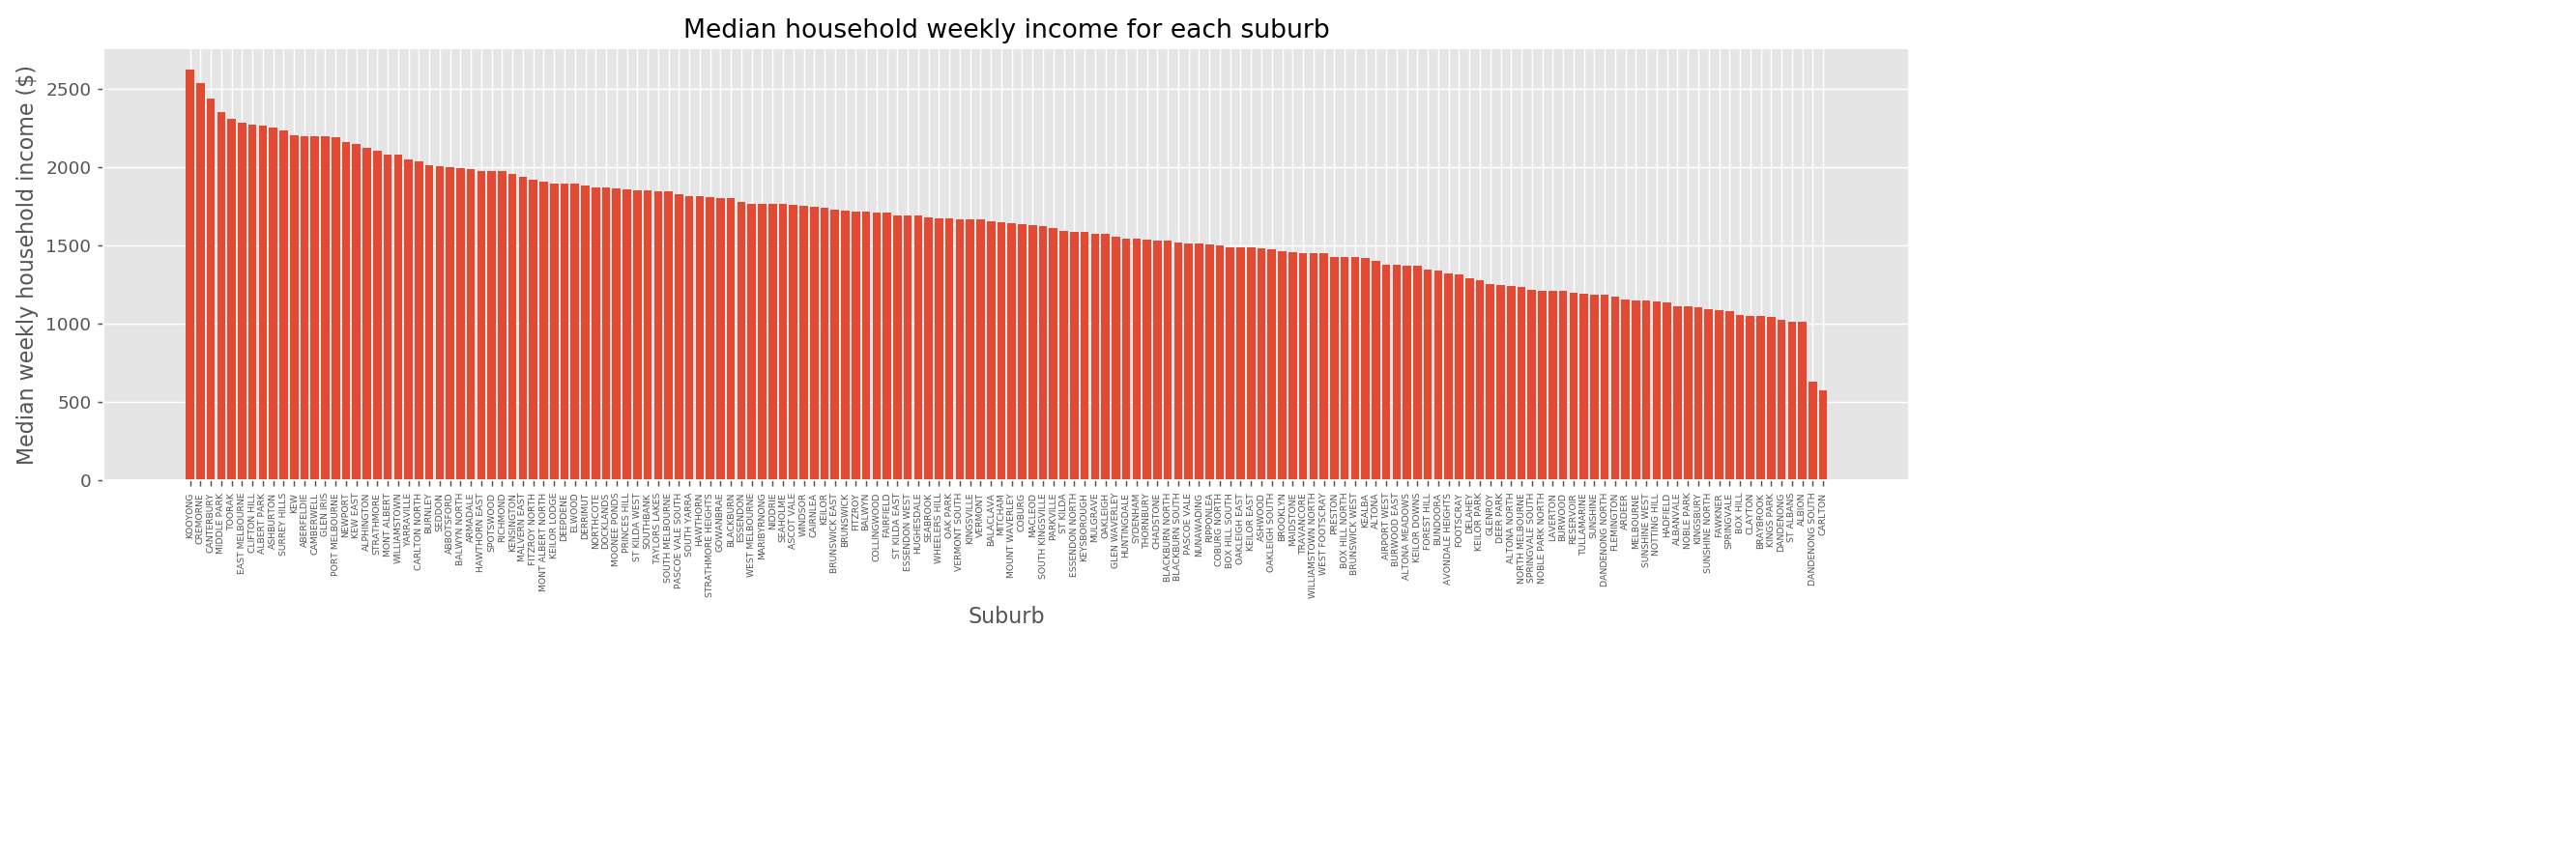

In [63]:
plot_bar_graph(suburb_by_income['Suburb'], suburb_by_income['Median houshold inc weekly'], 'Suburb', 'Median weekly household income ($)', 'Median household weekly income for each suburb')

### Median age

In [64]:
suburb_by_age = all_suburbs[['Suburb', 'Median age']].sort_values('Median age', ascending=False)
suburb_by_age.head(20)

,Suburb,Median age
157,DEEPDENE,47
69,DANDENONG SOUTH,47
146,WHEELERS HILL,46
34,KOOYONG,45
61,VERMONT SOUTH,45
63,TOORAK,45
116,KEILOR,44
78,SEAHOLME,44
104,AVONDALE HEIGHTS,44
49,CANTERBURY,44


In [65]:
suburb_by_age.tail(10)

,Suburb,Median age
140,WEST MELBOURNE,30
144,DOCKLANDS,30
93,SOUTHBANK,30
126,TRAVANCORE,29
127,NORTH MELBOURNE,28
132,NOTTING HILL,28
135,MELBOURNE,27
138,PARKVILLE,26
111,CLAYTON,25
108,CARLTON,24


In [66]:
#plot_bar_graph(suburb_by_age['Suburb'], suburb_by_age['Median age'], 'Suburb', 'Median age', 'Median age for each suburb')

### Total population

In [67]:
suburbs_pop = all_suburbs[['Suburb', 'Total population']].sort_values(by='Total population', ascending=False)
suburbs_pop.head(10)

,Suburb,Total population
47,RESERVOIR,49780
135,MELBOURNE,47026
150,GLEN WAVERLEY,40056
130,ST ALBANS,36840
23,MOUNT WAVERLEY,33346
51,PRESTON,32454
31,NOBLE PARK,30541
20,DANDENONG,29382
55,BUNDOORA,28370
119,RICHMOND,27408


In [68]:
suburbs_pop.tail(10)

,Suburb,Total population
9,HUNTINGDALE,1836
136,BROOKLYN,1818
77,KEILOR LODGE,1735
16,WILLIAMSTOWN NORTH,1578
67,RIPPONLEA,1557
97,ESSENDON WEST,1430
70,STRATHMORE HEIGHTS,996
34,KOOYONG,818
18,BURNLEY,757
69,DANDENONG SOUTH,157


<IPython.core.display.Javascript object>


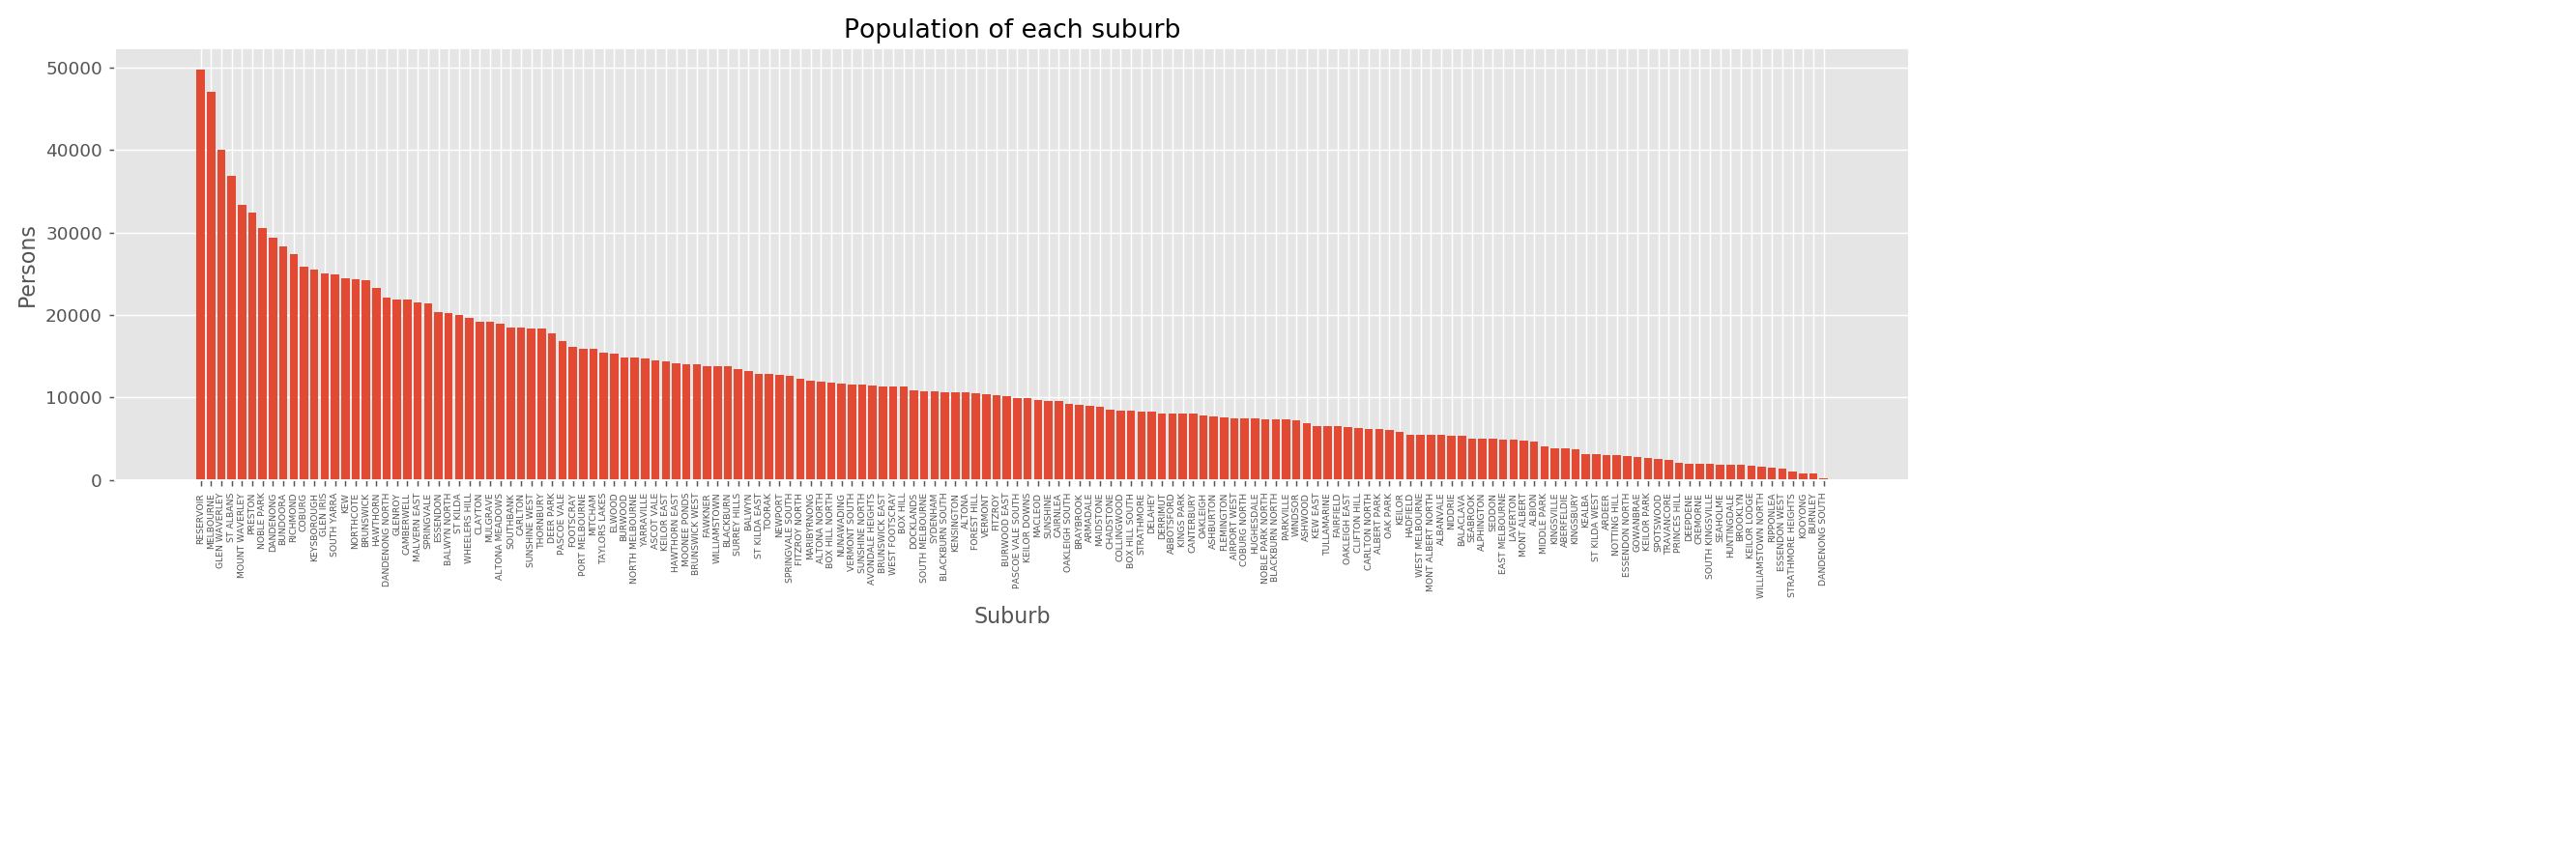

In [69]:
plot_bar_graph(suburbs_pop['Suburb'], suburbs_pop['Total population'], 'Suburb', 'Persons', 'Population of each suburb')

### Median house worth

In [70]:
house_by_price = df_housing[['Suburb', 'House price $ (2016)']].sort_values('House price $ (2016)', ascending=False).reset_index(drop=True)
house_by_price.head(10)

,Suburb,House price $ (2016)
0,TOORAK,4851000.0
1,EAST MELBOURNE,3655000.0
2,KOOYONG,2758000.0
3,CANTERBURY,2630000.0
4,DEEPDENE,2600000.0
5,ARMADALE,2390000.0
6,HAWTHORN,2325000.0
7,KEW,2240000.0
8,MIDDLE PARK,2238500.0
9,BALWYN,2170000.0


In [71]:
house_by_price.tail(10)

,Suburb,House price $ (2016)
144,ST ALBANS,510000.0
145,SEABROOK,509000.0
146,SYDENHAM,505000.0
147,ALTONA MEADOWS,495000.0
148,KEALBA,470000.0
149,DELAHEY,458000.0
150,DEER PARK,441000.0
151,ALBANVALE,439000.0
152,LAVERTON,430000.0
153,KINGS PARK,415000.0


<IPython.core.display.Javascript object>


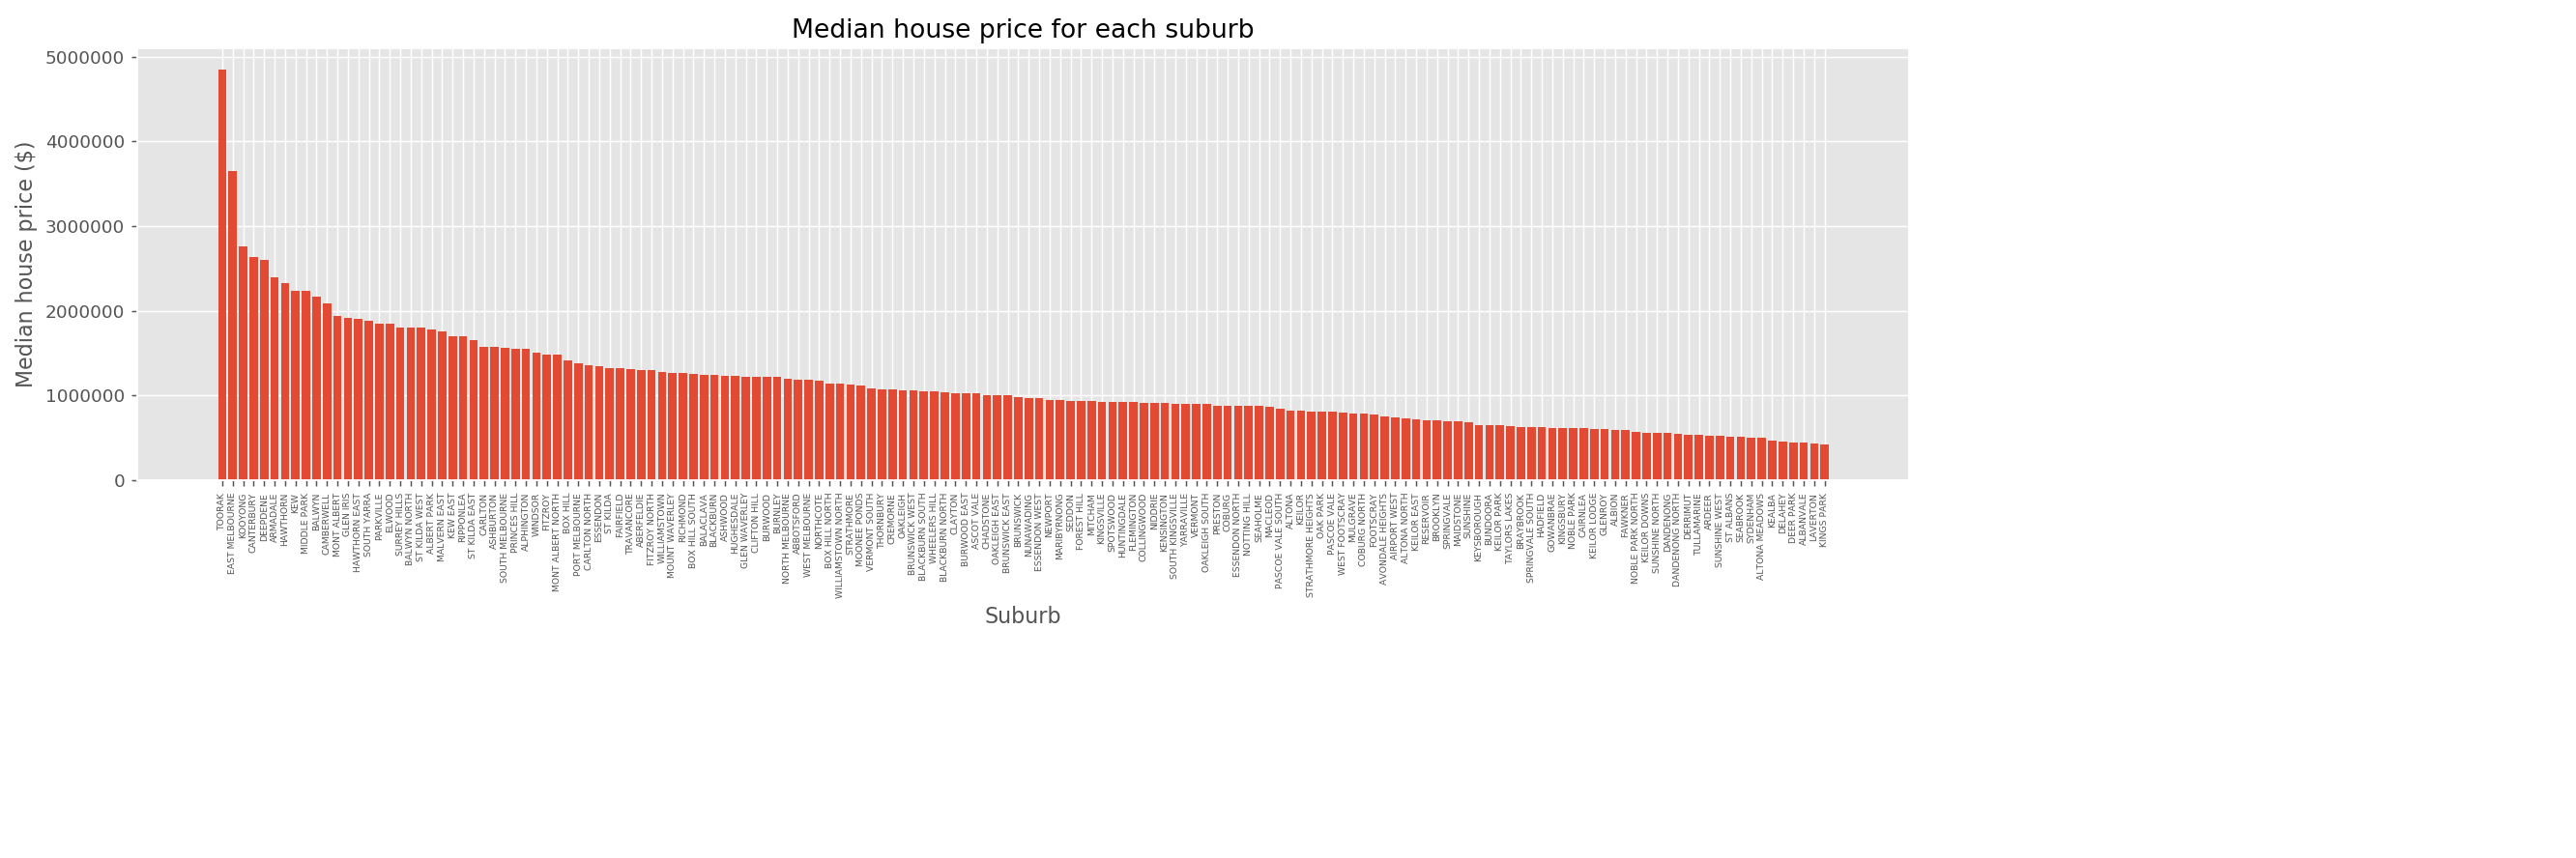

In [72]:
plot_bar_graph(house_by_price['Suburb'], house_by_price['House price $ (2016)'], 'Suburb', 'Median house price ($)', 'Median house price for each suburb')

### Median unit worth

In [73]:
unit_by_price = df_unit[['Suburb', 'Unit price $ (2016)']].sort_values('Unit price $ (2016)', ascending=False).reset_index(drop=True)
unit_by_price.head(10)

,Suburb,Unit price $ (2016)
0,ASHBURTON,1175000.0
1,CANTERBURY,1095000.0
2,BALWYN NORTH,1056500.0
3,TOORAK,1052500.0
4,DEEPDENE,960500.0
5,MONT ALBERT NORTH,932500.0
6,MOUNT WAVERLEY,850000.0
7,BOX HILL NORTH,779000.0
8,BOX HILL SOUTH,774500.0
9,ASHWOOD,771500.0


In [74]:
unit_by_price.tail(10)

,Suburb,Unit price $ (2016)
136,TRAVANCORE,363000.0
137,CARLTON,361500.0
138,DELAHEY,360000.0
139,DEER PARK,345000.0
140,SYDENHAM,342500.0
141,ST ALBANS,340000.0
142,DANDENONG,331500.0
143,DANDENONG SOUTH,329000.0
144,NOTTING HILL,325000.0
145,ALBION,240000.0


<IPython.core.display.Javascript object>


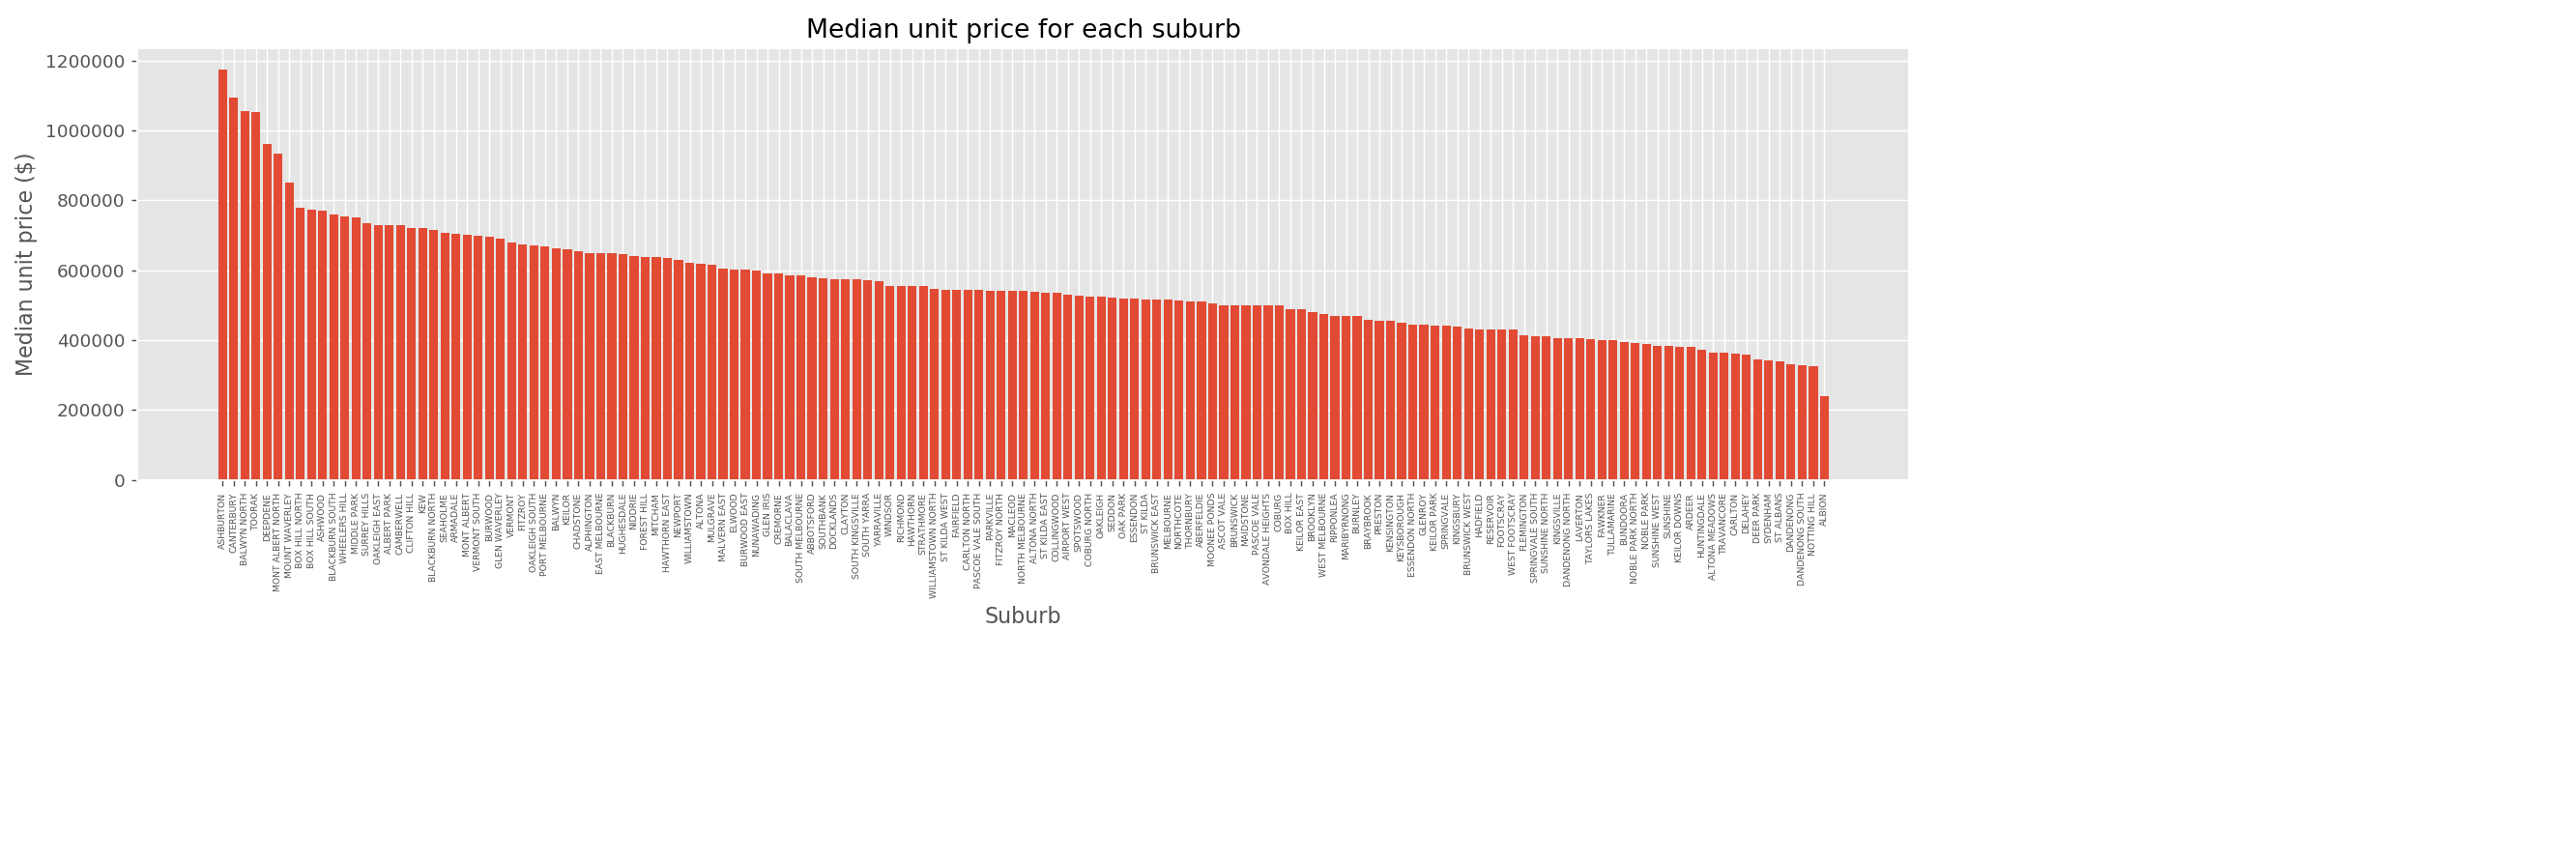

In [75]:
plot_bar_graph(unit_by_price['Suburb'], unit_by_price['Unit price $ (2016)'], 'Suburb', 'Median unit price ($)', 'Median unit price for each suburb')

<IPython.core.display.Javascript object>


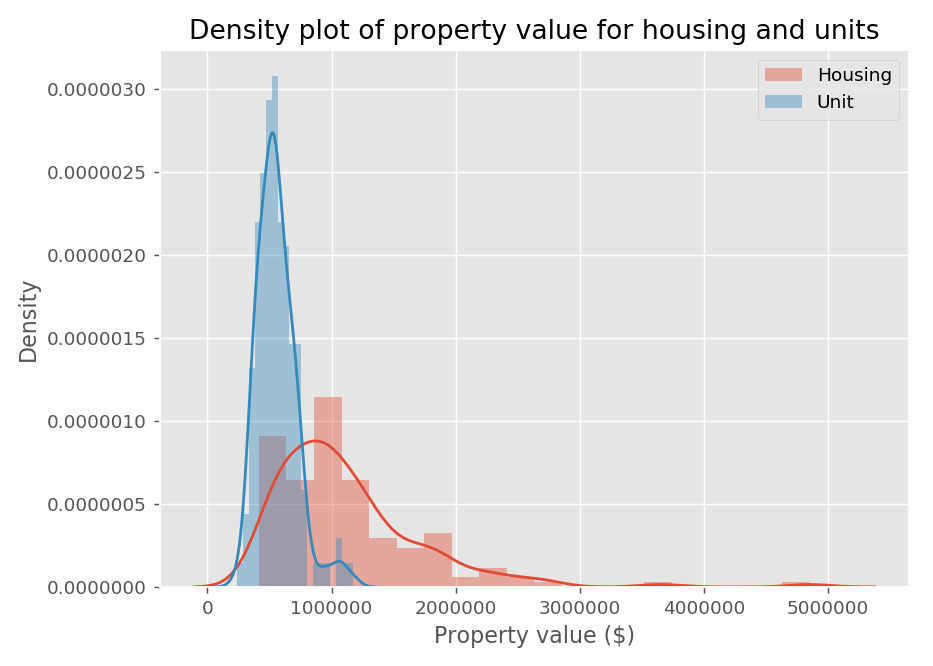

In [76]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(7,5))
sns.distplot(df_housing['House price $ (2016)'], bins=20, ax=ax)
sns.distplot(df_unit['Unit price $ (2016)'], bins=20, ax=ax)
ax.set_xlabel('Property value ($)')
ax.set_ylabel('Density')
ax.set_title('Density plot of property value for housing and units')
ax.legend(['Housing', 'Unit'])
plt.tight_layout()

### Discussion of the suburb profiles

The visualisations above reveal some important insight to the data. Firstly, Melbourne's most wealthy neighbourhoods in the form of house and unit prices and weekly household income are Canterbury, Kooyong, Toorak, Deepdene, Hawtorn, middle park and East Melbourne. With Toorak having the highest house price of all suburbs by a large margin. Meanwhile, the suburb of Deepdene is valuable for both apartment units and housing but interestingly not as high up in median income as the other wealthy suburbs but is tied for the highest median age of all suburbs. A possible reason could be that this suburb might have a larger population of retirees or people who bought these properties back when they were cheaper. On the other hand, there are suburbs like Cremorne with high household and personal income but moderate in house and unit price.

The choropleth maps show that most valuable areas for housing are mostly located in the eastern suburbs of Melbourne while the western suburbs are less valuable excluding areas in the inner Melbourne regions. On the other hand, apartment units’ prices are more evenly distributed, but the most expensive areas are still mostly in the eastern parts. Furthermore, the highest value places are all located in the inner eastern suburbs closer to the city and the median age of these areas are also one of the highest which is sensible as older people generally have more money and are more likely to own valuable property.

Looking at some of the least valuable and lowest income areas, it appears they are mostly located on the outskirts of Melbourne on the far west and south east. Analysing Melbourne city itself, we can note that younger people prefer to live in the city. The median age of Melbourne city at just 27 is among the lowest and the same goes for income. It would seem young professionals and students are the most popular demographic here. An interesting place to note are the suburbs of Carlton and Clayton both of which have very low weekly household incomes (500-1000) and ages (24-26). This is because these suburbs are located adjacent to Melbourne University and Monash University respectively. Thus, it is mostly populated by university students which accounts for these observations. 

Finally, the density plot shows that the distribution for house value is skewed to the right due to the high value neighbourhoods such as Toorak. Most houses in Melbourne cost somewhere around 900,000 to 1,100,000. Meanwhile, the distribution for apartment units is more normally distributed with an increase in value to the right tail. This is due to the suburbs 'Ashburton', 'Canterbury', 'Baldwyn North' and 'Toorak' which all have values above 1,000,000 which is in the ball park of the cost of most houses in Melbourne. The distribution plot shows that apartment units cost approximately 500,000 to 600,000. 


### Checking the correlations between features and property value

There are postive correlations between property price and certain features, in particular for mortgage and income. It should be noted that the correlation matrix assumes a linear relationship.

In [77]:
corr_matrix = df_housing[['House price $ (2016)', 'Median age', 'Median personal inc weekly', 'Median houshold inc weekly', 'Median rent weekly', 'Average household size', 'Median mortgage repay monthly', 'Median tot family inc weekly']].corr()
corr_matrix['House price $ (2016)'].sort_values(ascending=False)

House price $ (2016)             1.000000
Median tot family inc weekly     0.747847
Median mortgage repay monthly    0.719419
Median personal inc weekly       0.621186
Median houshold inc weekly       0.612368
Median rent weekly               0.594838
Median age                       0.228412
Average household size          -0.408608
Name: House price $ (2016), dtype: float64

In [78]:
from pandas.plotting import scatter_matrix

features = ['House price $ (2016)', 'Median personal inc weekly', 'Average household size', 'Median mortgage repay monthly', 'Median rent weekly', 'Median tot family inc weekly']
#scatter_matrix(df_housing[features], figsize=(15,15))

In [79]:
corr_matrix_unit = df_unit[['Unit price $ (2016)', 'Median age', 'Median personal inc weekly', 'Median houshold inc weekly', 'Median rent weekly', 'Average household size', 'Median mortgage repay monthly', 'Median tot family inc weekly']].corr()
corr_matrix_unit['Unit price $ (2016)'].sort_values(ascending=False)

Unit price $ (2016)              1.000000
Median mortgage repay monthly    0.671382
Median houshold inc weekly       0.602231
Median tot family inc weekly     0.599261
Median rent weekly               0.587156
Median age                       0.461252
Median personal inc weekly       0.377649
Average household size           0.064859
Name: Unit price $ (2016), dtype: float64

In [80]:
from pandas.plotting import scatter_matrix

features = ['Unit price $ (2016)', 'Median personal inc weekly', 'Average household size', 'Median mortgage repay monthly', 'Median rent weekly', 'Median tot family inc weekly']
#scatter_matrix(df_unit[features], figsize=(15,15))

In [81]:
gc.collect()

65

## Exploring the area with FourSquare

The following function retrieves up to 200 recommended venues for each suburb together with its details using FourSquare's Places API and returns a dataframe. The data period is selected to be the 1st of December 2016 so to be more consistant with the rest of the data.

In [82]:
def get_all_venues(name, lat, lon):
    
    venues = []
    
    for name, lat, lon in zip(name, lat, lon):
        
        print(name)
        
        CLIENT_ID = 'CLIENT ID'
        CLIENT_SECRET = 'CLIENT_SECRET'
        VERSION = '20161201'
        
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, v=VERSION, ll=f"{lat}, {lon}", limit=200)
        
        data = requests.get(url, params=params).json()
        
        for i in data['response']['groups'][0]['items']:
            
            location = i['venue']['location']
            v_name = i['venue']['name']
            cat = i['venue']['categories'][0]['name']
            v_lat = location['lat']
            v_lon = location['lng']
            if location['formattedAddress'] != None:
                address = ', '.join(location['formattedAddress'])
            else:
                address = 'Address not available'
                
            venues.append((name, cat, lat, lon, v_name, v_lat, v_lon, address))
            
    df = pd.DataFrame(venues)
    df.columns = ['Suburb', 'Category', 'Suburb lat', 'Suburb lon', 'Venue name', 'Lat', 'Lon', 'Venue address']

    print('\nDone')
    
    return df

In [83]:
# %%time
# df_venues = get_all_venues(df_coordinates['Suburb'], df_coordinates['Latitude'], df_coordinates['Longitude'])

In [84]:
gc.collect()

0

The result is saved as an excel file for future use.

In [85]:
#df_venues.to_excel('all_venues.xlsx')

In [86]:
df_venues = pd.read_excel('all_venues.xlsx')

In [87]:
df_venues.head(10)

,Suburb,Category,Suburb lat,Suburb lon,Venue name,Lat,Lon,Venue address
0,BRUNSWICK EAST,Café,-37.76888,144.977682,Milkwood,-37.767576,144.980241,"120 Nicholson St., Melbourne VIC 3057, Australia"
1,BRUNSWICK EAST,Bar,-37.76888,144.977682,Mr Wilkinson,-37.769401,144.971969,"295 Lygon St, Melbourne VIC 3056, Australia"
2,BRUNSWICK EAST,Greek Restaurant,-37.76888,144.977682,Hellenic Republic,-37.764496,144.973040,"434 Lygon St, Melbourne VIC 3057, Australia"
3,BRUNSWICK EAST,Coffee Shop,-37.76888,144.977682,Padre Coffee,-37.764107,144.973280,"438-440 Lygon St (Stewart St), Brunswick East ..."
4,BRUNSWICK EAST,Café,-37.76888,144.977682,East Elevation,-37.767682,144.972339,"351 Lygon St, Melbourne VIC 3057, Australia"
5,BRUNSWICK EAST,Sake Bar,-37.76888,144.977682,Kumo Izakaya & Sake Bar,-37.773424,144.971492,"152 Lygon St (O'Conner St), Melbourne VIC 3057..."
6,BRUNSWICK EAST,Bar,-37.76888,144.977682,The Alderman,-37.773997,144.971299,"134 Lygon St, Brunswick East VIC 3057, Australia"
7,BRUNSWICK EAST,Chocolate Shop,-37.76888,144.977682,Monsieur Truffe,-37.767579,144.972279,"351 Lygon St, Brunswick VIC 3057, Australia"
8,BRUNSWICK EAST,Community Center,-37.76888,144.977682,CERES Community Environment Park,-37.765743,144.983281,"Roberts St (Stewart St), Brunswick VIC 3057, A..."
9,BRUNSWICK EAST,Brewery,-37.76888,144.977682,Temple Brewing Company,-37.776028,144.971710,"122 Weston St, Brunswick VIC 3057, Australia"


In [88]:
len(df_venues)

14961

Checking out the catagories and their respective total. Cafes takes the cake as the most common vanue in the region by a large amount, Melbourne is very well known for it's cafes and the coffee is regarded as one of the best in the world.

In [89]:
df_venues['Category'].value_counts()

Café                         2575
Fast Food Restaurant          472
Grocery Store                 424
Supermarket                   422
Pub                           362
Coffee Shop                   360
Park                          342
Pizza Place                   339
Gym                           338
Sandwich Place                328
Vietnamese Restaurant         312
Convenience Store             304
Bakery                        304
Bar                           299
Burger Joint                  281
Portuguese Restaurant         251
Japanese Restaurant           247
Italian Restaurant            246
Shopping Mall                 243
Thai Restaurant               225
Electronics Store             216
Chinese Restaurant            183
Malay Restaurant              159
Department Store              154
Asian Restaurant              142
Gym / Fitness Center          141
Indian Restaurant             135
Australian Restaurant         123
Middle Eastern Restaurant     120
Korean Restaur

Transforming the categories into a dummy variable using pandas get_dummies method.

In [90]:
df_dummy = pd.concat([df_venues[['Suburb']], pd.get_dummies(df_venues['Category'])], axis=1)
df_dummy_grp = df_dummy.groupby('Suburb').sum()
df_dummy_grp.head()

,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
Suburb,,,,,,,,,,,,,,,,,,,,,
ABBOTSFORD,1,0,1,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,0,0
ABERFELDIE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIRPORT WEST,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALBANVALE,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALBERT PARK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


Lets view the categories for each suburb that is more than 1.

In [91]:
for i in df_dummy_grp.index.tolist():
    print(f"------{i}------")
    print(df_dummy_grp.loc[i][df_dummy_grp.loc[i] > 1].sort_values(ascending=False))
    print('\n')

------ABBOTSFORD------
Café                             18
Vietnamese Restaurant            10
Coffee Shop                       5
Pub                               4
Vegetarian / Vegan Restaurant     3
Thai Restaurant                   3
Pizza Place                       3
Bakery                            3
Bar                               3
Wine Bar                          2
Breakfast Spot                    2
Australian Restaurant             2
BBQ Joint                         2
Cocktail Bar                      2
Brewery                           2
Burger Joint                      2
Gastropub                         2
Ice Cream Shop                    2
Japanese Restaurant               2
Asian Restaurant                  2
Name: ABBOTSFORD, dtype: uint8


------ABERFELDIE------
Café                     21
Electronics Store         5
Gym                       4
Japanese Restaurant       3
Bakery                    3
Coffee Shop               3
Dessert Shop              3
Thai 

Name: PORT MELBOURNE, dtype: uint8


------PRESTON------
Café                             16
Pizza Place                       5
Bar                               4
Electronics Store                 3
Bakery                            3
Sandwich Place                    3
Japanese Restaurant               3
Coffee Shop                       3
Department Store                  2
BBQ Joint                         2
Burger Joint                      2
Vietnamese Restaurant             2
Diner                             2
Vegetarian / Vegan Restaurant     2
Hotel                             2
Mexican Restaurant                2
Park                              2
Shopping Mall                     2
Supermarket                       2
Australian Restaurant             2
Name: PRESTON, dtype: uint8


------PRINCES HILL------
Café                             18
Bar                              12
Italian Restaurant                5
Zoo Exhibit                       4
Pub                     

Checking out the categories for the top 10 suburbs with the most valuable properties.

In [92]:
for i in list(set(unit_by_price.head(10)['Suburb'].tolist() + house_by_price.head(10)['Suburb'].tolist())):
    print(f"------{i}------")
    #print(df_dummy_grp.loc[i].sort_values(ascending=False)[0:10])
    print(df_dummy_grp.loc[i][df_dummy_grp.loc[i] > 1].sort_values(ascending=False))
    print('\n')

------ARMADALE------
Café                   32
Japanese Restaurant     5
Italian Restaurant      5
Coffee Shop             5
Park                    4
Convenience Store       3
Train Station           2
Deli / Bodega           2
Burger Joint            2
Chinese Restaurant      2
Grocery Store           2
Gas Station             2
Supermarket             2
Pizza Place             2
Pub                     2
Shopping Mall           2
Breakfast Spot          2
Name: ARMADALE, dtype: uint8


------MONT ALBERT NORTH------
Café                     18
Chinese Restaurant        6
Malay Restaurant          4
Department Store          4
Vietnamese Restaurant     3
Movie Theater             3
Japanese Restaurant       3
Gym                       3
Electronics Store         2
Burger Joint              2
Coffee Shop               2
Dessert Shop              2
Dumpling Restaurant       2
Grocery Store             2
Food Court                2
Sandwich Place            2
Gym / Fitness Center      2


### Dicussion of venues for top 10 most valuable suburbs

From the table above, these wealthy suburbs posses a wide selection of restaurants of mainly east Asian and Italian. While places such as bars and pubs are also common including others such as breweries, wine bars and beer gardens. Business and services such as parks, recreational and sporting facilities, stores and shops, movie theatres, etc are also prominent in these suburbs.

Getting the categories for the suburbs with the lowest property values. Carlton is removed from the list since it contains mostly commercial shops and some Melbourne University buildings as well as being largely populated by university students. Which makes this suburb an outlier.

In [93]:
lowest = list(set(unit_by_price.tail(11)['Suburb'].tolist() + house_by_price.tail(11)['Suburb'].tolist()))
lowest.remove('CARLTON')

for i in lowest:
    print(f"------{i}------")
    #print(df_dummy_grp.loc[i].sort_values(ascending=False)[0:10])
    print(df_dummy_grp.loc[i][df_dummy_grp.loc[i] > 1].sort_values(ascending=False))
    print('\n')

------DELAHEY------
Café                     9
Fast Food Restaurant     9
Sandwich Place           5
Portuguese Restaurant    5
Grocery Store            5
Bakery                   3
Supermarket              3
Shopping Mall            3
Pub                      3
Pizza Place              3
Gym                      3
Convenience Store        3
Department Store         2
Burger Joint             2
Train Station            2
Electronics Store        2
Thai Restaurant          2
Racetrack                2
Hotel                    2
Name: DELAHEY, dtype: uint8


------KINGS PARK------
Fast Food Restaurant     9
Café                     7
Portuguese Restaurant    6
Grocery Store            4
Sandwich Place           4
Vietnamese Restaurant    3
Burger Joint             3
Convenience Store        3
Electronics Store        3
Bakery                   3
Pizza Place              3
Pub                      3
Shopping Mall            3
Supermarket              3
Gym                      2
Thai Rest

### Dicussion of venues for top 10 least valuable suburbs

The table above shows the suburbs with the least valuable properties. Fast food restaurants are a very common venue in these neighbourhoods as well as portuguese restaurants. The suburbs here generally do not appear to have as many places and facilities compared their wealthier counterparts however, department stores and shopping malls appear to be more common. In addition, bars and pubs are available but pubs are more common than bars.

### Setting the top 10 venues for every suburb as a dataframe.

In [94]:
df_top_venues = pd.DataFrame()

for row in df_dummy_grp.index.tolist():
    df_temp = pd.DataFrame(df_dummy_grp.loc[row].sort_values(ascending=False)[0:10].index, columns=[row]).T
    df_top_venues = pd.concat([df_top_venues, df_temp], axis=0)
    
df_top_venues.reset_index(inplace=True)
df_top_venues.columns = ['Suburb'] + ['Most common ranking: ' + str(i) for i in np.arange(1,11)]

In [95]:
df_top_venues.head()

,Suburb,Most common ranking: 1,Most common ranking: 2,Most common ranking: 3,Most common ranking: 4,Most common ranking: 5,Most common ranking: 6,Most common ranking: 7,Most common ranking: 8,Most common ranking: 9,Most common ranking: 10
0,ABBOTSFORD,Café,Vietnamese Restaurant,Coffee Shop,Pub,Bakery,Pizza Place,Bar,Thai Restaurant,Vegetarian / Vegan Restaurant,Breakfast Spot
1,ABERFELDIE,Café,Electronics Store,Gym,Dessert Shop,Pub,Coffee Shop,Bakery,Japanese Restaurant,Thai Restaurant,Pizza Place
2,AIRPORT WEST,Café,Supermarket,Grocery Store,Fast Food Restaurant,Sandwich Place,Shopping Mall,Convenience Store,Portuguese Restaurant,Electronics Store,Thai Restaurant
3,ALBANVALE,Fast Food Restaurant,Café,Portuguese Restaurant,Grocery Store,Vietnamese Restaurant,Electronics Store,Convenience Store,Shopping Mall,Pizza Place,Burger Joint
4,ALBERT PARK,Café,Coffee Shop,Beach,Breakfast Spot,Bar,Pub,Burger Joint,Mexican Restaurant,Japanese Restaurant,Seafood Restaurant


## Clustering

Creating dataframe for clustering containing the ratio of category for every suburb

In [96]:
from sklearn.preprocessing import MinMaxScaler

def get_df_precluster(dwelling_type):
    
    if dwelling_type == 'h':
        
        scaler = MinMaxScaler()

        transformed = pd.DataFrame(scaler.fit_transform(df_housing[['House price $ (2016)']]), columns=['House value'])
        df_transformed = pd.concat([transformed, df_housing['Suburb']], axis=1)

        df_for_cluster = df_dummy.groupby('Suburb').mean().reset_index(drop=False)
        df_for_cluster = df_for_cluster.merge(right=df_transformed, how='right', left_on='Suburb', right_on='Suburb')
        df_for_cluster.fillna(0, inplace=True)


#         transformed = pd.DataFrame(scaler.fit_transform(all_suburbs[['Median houshold inc weekly']]), columns=['Med hhd inc'])
#         df_transformed = pd.concat([transformed, all_suburbs['Suburb']], axis=1)
#         df_for_cluster = df_for_cluster.merge(right=df_transformed, how='left', left_on='Suburb', right_on='Suburb')

        df_for_cluster.drop(columns=['Suburb'], inplace=True)
        
    elif dwelling_type == 'u':
        
        scaler = MinMaxScaler()

        transformed = pd.DataFrame(scaler.fit_transform(df_unit[['Unit price $ (2016)']]), columns=['Unit value'])
        df_transformed = pd.concat([transformed, df_unit['Suburb']], axis=1)

        df_for_cluster = df_dummy.groupby('Suburb').mean().reset_index(drop=False)
        df_for_cluster = df_for_cluster.merge(right=df_transformed, how='right', left_on='Suburb', right_on='Suburb')
        df_for_cluster.fillna(0, inplace=True)


#         transformed = pd.DataFrame(scaler.fit_transform(all_suburbs[['Median houshold inc weekly']]), columns=['Med hhd inc'])
#         df_transformed = pd.concat([transformed, all_suburbs['Suburb']], axis=1)
#         df_for_cluster = df_for_cluster.merge(right=df_transformed, how='left', left_on='Suburb', right_on='Suburb')

        df_for_cluster.drop(columns=['Suburb'], inplace=True)
        
    else:
        print("Please enter 'h' for housing or 'u' for units")
        
    return df_for_cluster

In [97]:
def return_df(labels, dwelling_type):
    
    if dwelling_type == 'h':
        
        df_cluster = df_top_venues.merge(right=df_housing[['Suburb', 'House price $ (2016)']], how='right', left_on='Suburb', right_on='Suburb')
        df_cluster = pd.concat([pd.Series(labels, name='Cluster'), df_cluster], axis=1)
        df_cluster = df_cluster.merge(right=df_coordinates, how='left', left_on='Suburb', right_on='Suburb')
        df_cluster = df_cluster[list(df_cluster.columns[:2]) + [df_cluster.columns[-3]] + list(df_cluster.columns[-2:]) + list(df_cluster.columns[2:12])]
        
    elif dwelling_type == 'u':
        
        df_cluster = df_top_venues.merge(right=df_unit[['Suburb', 'Unit price $ (2016)']], how='right', left_on='Suburb', right_on='Suburb')
        df_cluster = pd.concat([pd.Series(labels, name='Cluster'), df_cluster], axis=1)
        df_cluster = df_cluster.merge(right=df_coordinates, how='left', left_on='Suburb', right_on='Suburb')
        df_cluster = df_cluster[list(df_cluster.columns[:2]) + [df_cluster.columns[-3]] + list(df_cluster.columns[-2:]) + list(df_cluster.columns[2:12])]
    
    else:
        print("Please enter 'h' for housing or 'u' for units")
        
    return df_cluster

In [98]:
df_for_cluster_h = get_df_precluster('h')

In [99]:
df_for_cluster_u = get_df_precluster('u')

In [100]:
len(df_for_cluster_h)

154

In [101]:
len(df_for_cluster_u)

146

### Instantiating clustering

The data will be tested by three clustering techniques: kmeans, agglomerative and gaussian mixture.

# PCA + TSNE

In [102]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [103]:
def get_pca(data, n):
    
    n_component = n
    pca = PCA(n_components=n_component)
    pca_transformed = pca.fit_transform(data)
    
    return (pca_transformed, np.sum(pca.explained_variance_ratio_))

In [104]:
tsne = TSNE(n_components=2, random_state=0)
tsne_transformed = tsne.fit_transform(get_pca(df_for_cluster_h, 50)[0])

<IPython.core.display.Javascript object>


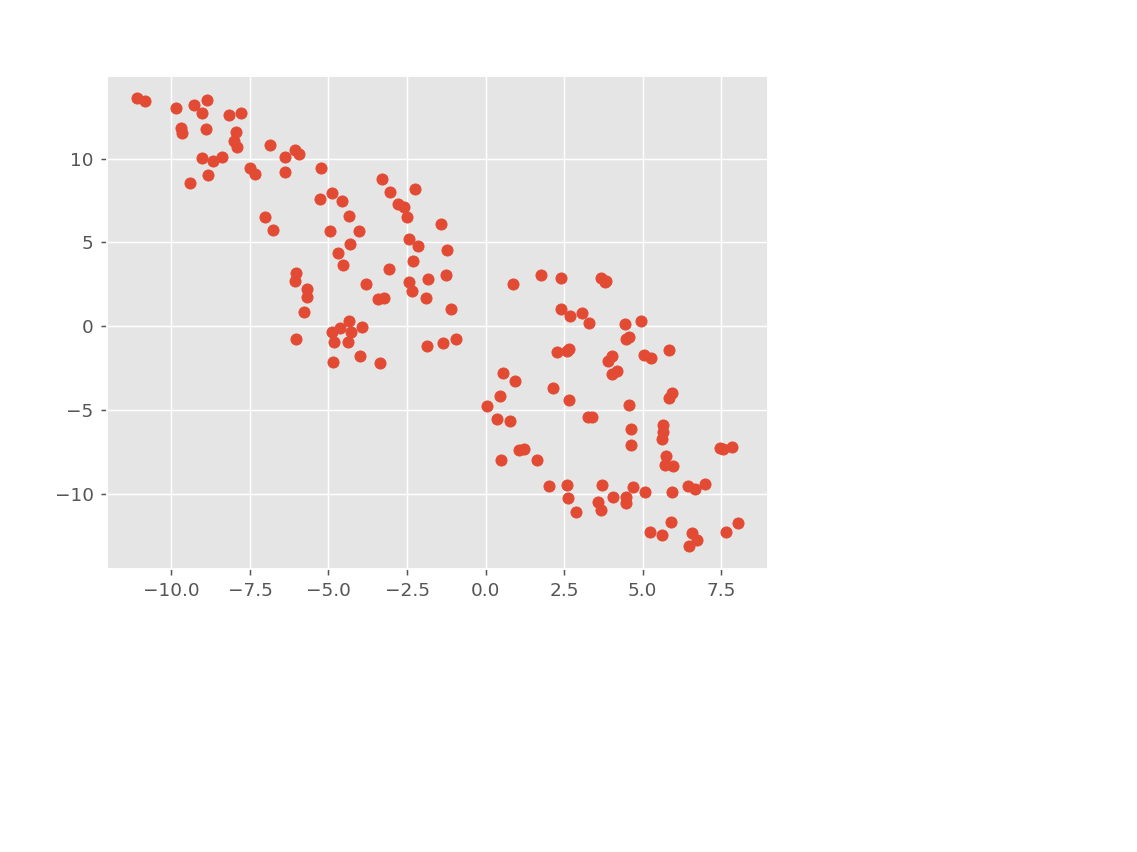

In [105]:
fig, ax = plt.subplots()
ax.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1])

## KMEANS

In [106]:
from sklearn.cluster import KMeans

def kmeans(data, n, dwelling_type):
    
    if dwelling_type == 'h':
        
        kmeans = KMeans(n_clusters=n, init='k-means++', n_init=100, random_state=7).fit(data)
        labels = kmeans.labels_
        df_km = return_df(labels, 'h')
        
    elif dwelling_type == 'u':
        
        kmeans = KMeans(n_clusters=n, init='k-means++', n_init=100, random_state=7).fit(data)
        labels = kmeans.labels_
        df_km = return_df(labels, 'u')
    else:
        print("Please enter 'h' for housing or 'u' for units")
        
    return df_km

In [107]:
df_km_h = kmeans(get_pca(df_for_cluster_h, 50)[0], 5, 'h')

In [108]:
get_pca(df_for_cluster_h, 50)[1]

0.985083948959152

In [109]:
df_km_u = kmeans(get_pca(df_for_cluster_u, 50)[0], 5, 'u')

In [110]:
get_pca(df_for_cluster_u, 50)[1]

0.987356688242035

In [111]:
def preview_plot(data1, data2):

    fig, ax = plt.subplots(1,2, figsize=(10,5))
      
    ax[0].scatter(data1['Longitude'], data1['Latitude'], c=data1['Cluster'])
    ax[0].set_title(f"Housing cluster")
    ax[1].scatter(data2['Longitude'], data2['Latitude'], c=data2['Cluster'])
    ax[1].set_title(f"Units cluster")
    ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    plt.tight_layout()

<IPython.core.display.Javascript object>


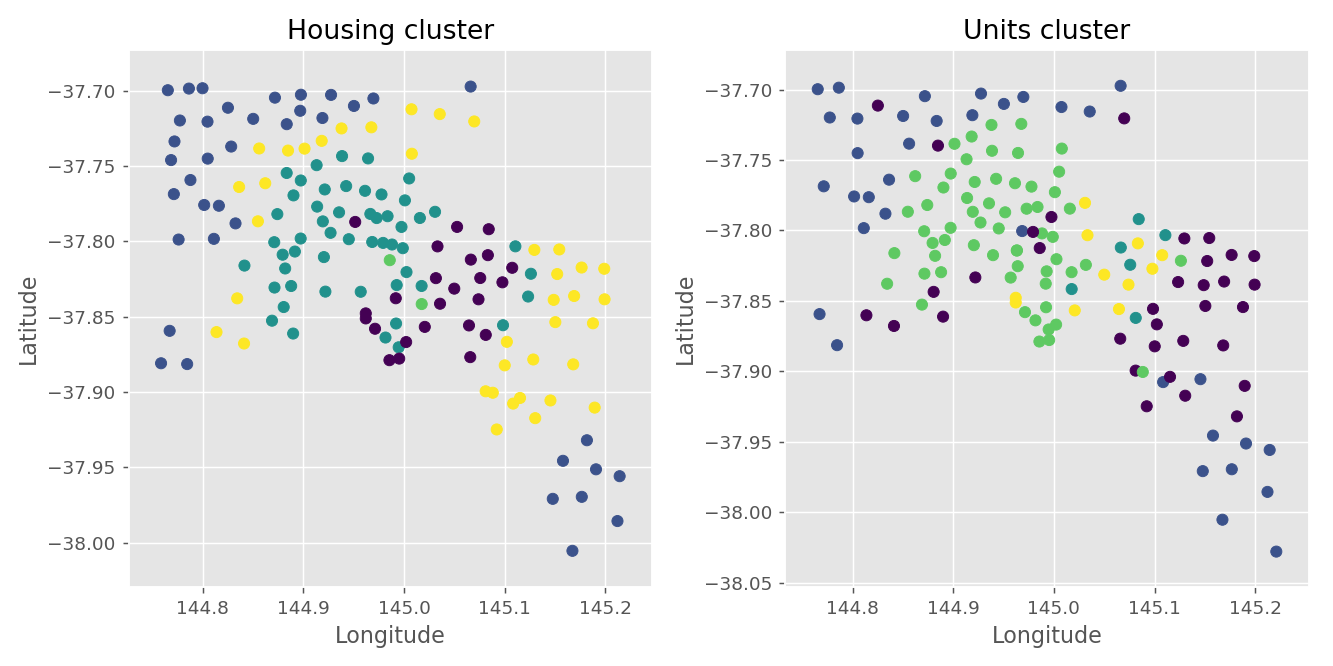

In [112]:
preview_plot(df_km_h, df_km_u)

In [113]:
# fig, ax = plt.subplots()
# ax.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=df_km['Cluster'])

Elbow method

In [114]:
# sse = {}

# for k in np.arange(1,10):
#     kmean = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=7).fit(get_pca(df_for_cluster_h, 50)[0])
#     sse[k] = kmean.inertia_

# fig, ax = plt.subplots()
# ax.plot(list(sse.keys()), list(sse.values()))
# ax.set_xticks(np.arange(1,15))
# ax.set_xlabel('N clusters')
# ax.set_ylabel('SSE')

Silhouette score

In [115]:
#from sklearn.metrics import silhouette_score

# for k in np.arange(2, 10):
#     kmean = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=7).fit(get_pca(df_for_cluster_h, 50)[0])
#     silhouette = silhouette_score(get_pca(df_for_cluster_h, 50)[0], kmean.labels_, metric='euclidean')
#     print(f"n cluster: {k}, silhouette score: {silhouette}")

## AGGLOMERATIVE CLUSTERING

In [116]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

Dendrogram of agglomerative clustering

<IPython.core.display.Javascript object>


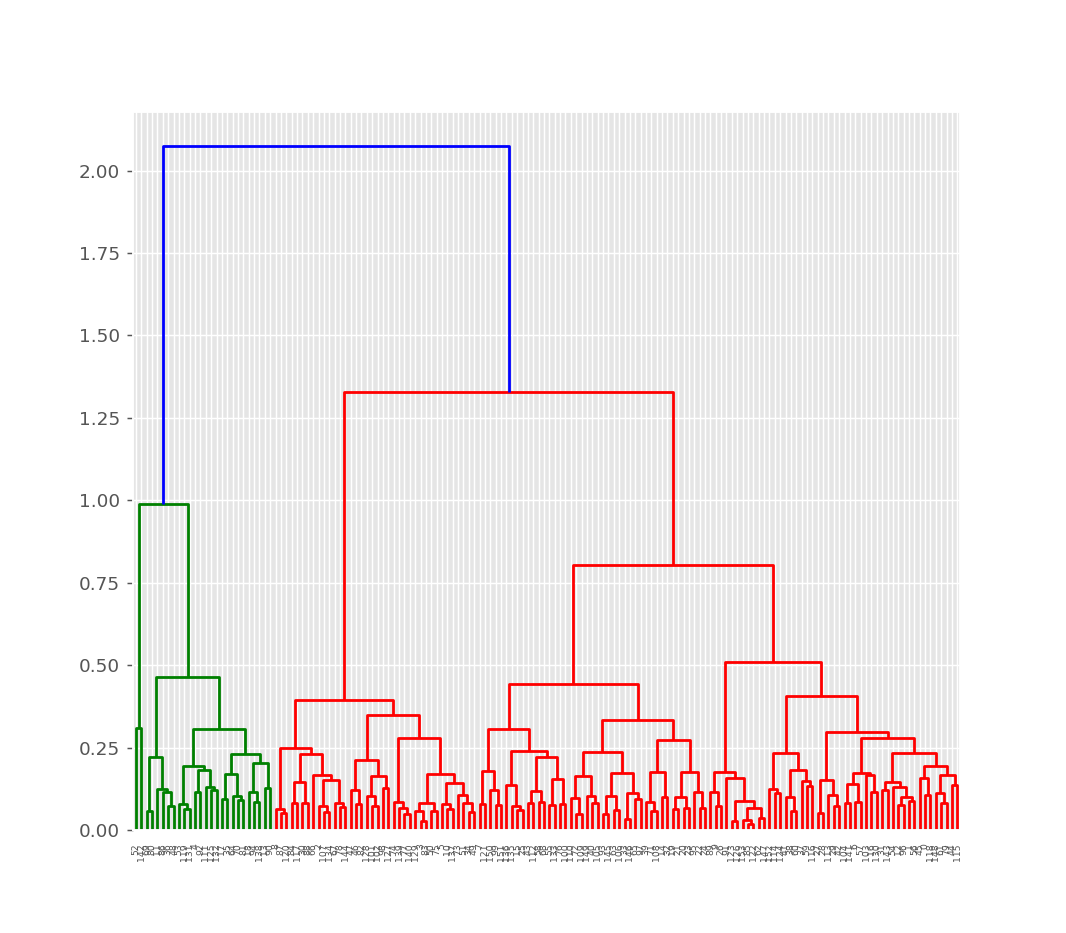

In [117]:
fig, ax = plt.subplots(figsize=(8,7))
dendrogram = hierarchy.dendrogram(hierarchy.linkage(get_pca(df_for_cluster_h, 50)[0], method='ward'), ax=ax)

In [118]:
from sklearn.cluster import AgglomerativeClustering

def agg_clustering(data, n, dwelling_type):
    
    if dwelling_type == 'h':
        
        ac = AgglomerativeClustering(n_clusters=n).fit(data)
        labels = ac.labels_
        hier_df = return_df(labels, 'h')
        
    elif dwelling_type == 'u':
        
        ac = AgglomerativeClustering(n_clusters=n).fit(data)
        labels = ac.labels_
        hier_df = return_df(labels, 'u')
        
    else:
        print("Please enter 'h' for housing or 'u' for units")
        
    return hier_df

In [119]:
hier_df_h = agg_clustering(get_pca(df_for_cluster_h, 50)[0], 5, 'h')

In [120]:
hier_df_u = agg_clustering(get_pca(df_for_cluster_u, 50)[0], 5, 'u')

<IPython.core.display.Javascript object>


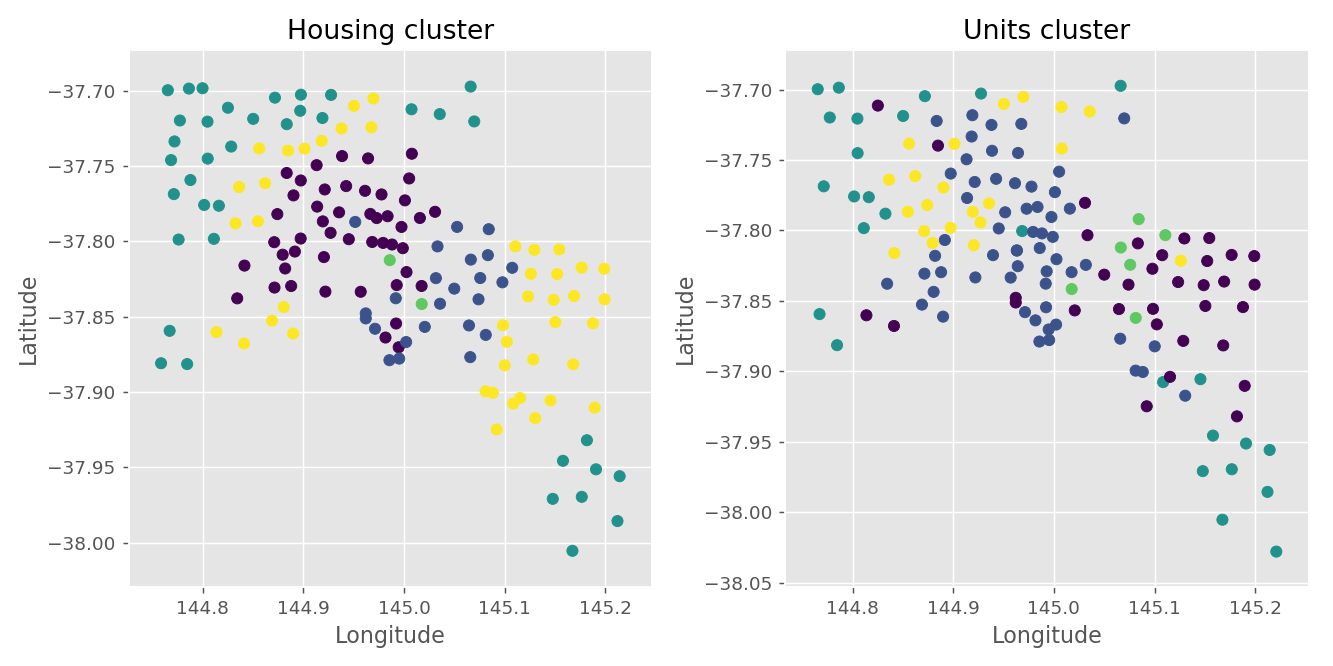

In [121]:
preview_plot(hier_df_h, hier_df_u)

In [122]:
# fig, ax = plt.subplots()
# ax.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=hier_df['Cluster'])

# GAUSSIAN MIXTURE

In [123]:
from sklearn.mixture import GaussianMixture

def gaus_mix(data, n, dwelling_type):
    
    if dwelling_type == 'h':
        
        gm = GaussianMixture(n_components=n, covariance_type='full', n_init=20, max_iter=100, random_state=7).fit(data)
        labels = gm.predict(data)
        df_gm = return_df(labels, 'h')
        
    elif dwelling_type == 'u':
        
        gm = GaussianMixture(n_components=n, covariance_type='full', n_init=20, max_iter=100, random_state=7).fit(data)
        labels = gm.predict(data)
        df_gm = return_df(labels, 'u')
        
    else:
        print("Please enter 'h' for housing or 'u' for units")
        
    return df_gm

In [124]:
df_gm_h = gaus_mix(get_pca(df_for_cluster_h, 50)[0], 5, 'h')

In [125]:
df_gm_u = gaus_mix(get_pca(df_for_cluster_u, 50)[0], 5, 'u')

<IPython.core.display.Javascript object>


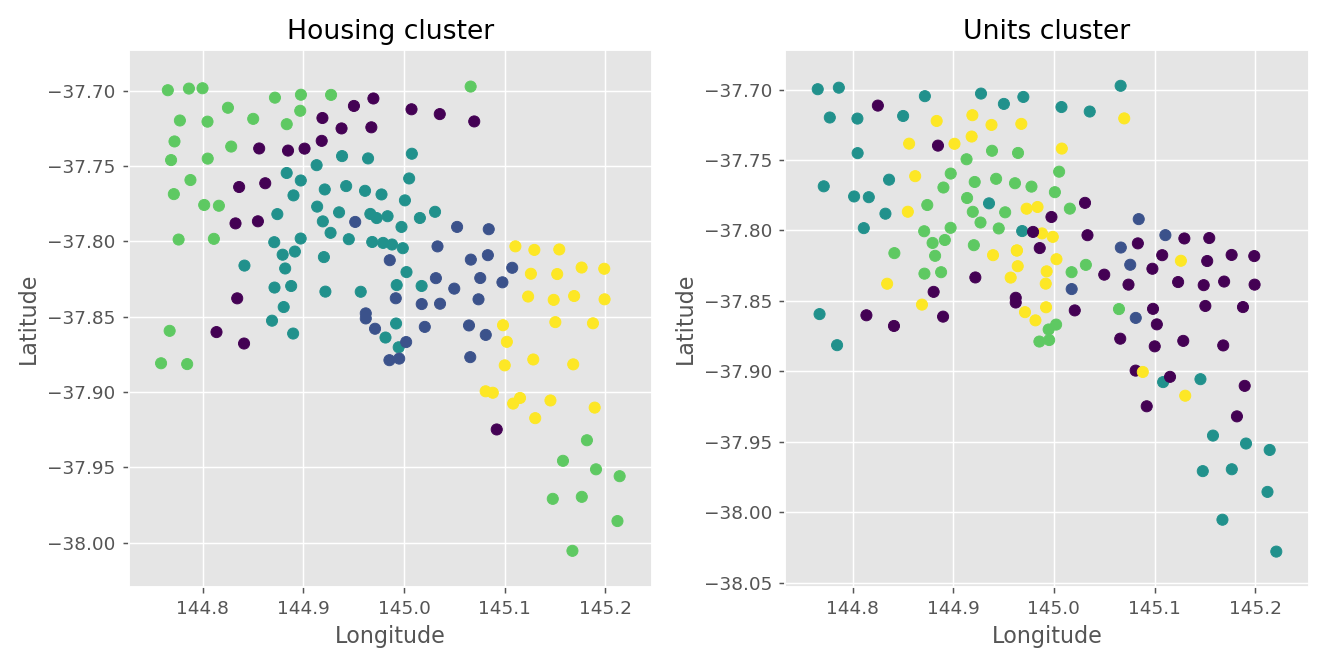

In [126]:
preview_plot(df_gm_h, df_gm_u)

In [127]:
# fig, ax = plt.subplots()
# ax.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=df_gm['Cluster'])

AIC and BIC

In [128]:
# from sklearn.mixture import GMM

# n_components = np.arange(1, 10)
# models = [GaussianMixture(n_components=n, covariance_type='full', n_init=20, max_iter=100, random_state=7).fit(get_pca(df_for_cluster_h, 50)[0])
#           for n in n_components]

# fig, ax = plt.subplots()
# ax.plot(n_components, [m.bic(get_pca(df_for_cluster_h, 50)[0]) for m in models], label='BIC')
# ax.plot(n_components, [m.aic(get_pca(df_for_cluster_h, 50)[0]) for m in models], label='AIC')
# ax.legend(loc='best')
# ax.set_xlabel('n_components');

All clustering methods returns similar clusters. However, agglomerative cluster will be used since the number of components is not clear for gaussian mixture is difficult to select even when using BIC and AIC while kmeans suggest 4 or 5 clusters as optimum using the elbow method and gap statistics. But, agglomerative clustering returns the overall most satisfactory clusters using clusters of 5.

View basic statistics for property value of each cluster

In [129]:
def get_cluster(df_cluster_):
    c_0 = df_cluster_[df_cluster_['Cluster'] == 0]
    c_1 = df_cluster_[df_cluster_['Cluster'] == 1]
    c_2 = df_cluster_[df_cluster_['Cluster'] == 2]
    c_3 = df_cluster_[df_cluster_['Cluster'] == 3]
    c_4 = df_cluster_[df_cluster_['Cluster'] == 4]
    return (c_0, c_1, c_2, c_3, c_4)

In [130]:
hier_df_h[['Cluster', 'House price $ (2016)']].groupby('Cluster').describe()

House price $ (2016)                                          \
                       count          mean            std        min   
Cluster                                                                
0                       47.0  1.114649e+06  249704.628008   694000.0   
1                       24.0  2.013000e+06  332300.381400  1567500.0   
2                       38.0  5.974474e+05  117387.081422   415000.0   
3                        2.0  4.253000e+06  845699.710299  3655000.0   
4                       43.0  9.895698e+05  219794.752239   560000.0   

                                                     
               25%        50%        75%        max  
Cluster                                              
0         916500.0  1075000.0  1302500.0  1577000.0  
1        1791500.0  1890000.0  2238875.0  2758000.0  
2         512500.0   596500.0   650000.0   868000.0  
3        3954000.0  4253000.0  4552000.0  4851000.0  
4         872500.0  1000000.0  1137750.0  1480000.0

In [131]:
hier_df_u[['Cluster', 'Unit price $ (2016)']].groupby('Cluster').describe()

Unit price $ (2016)                                                  \
                      count          mean           std       min       25%   
Cluster                                                                       
0                      34.0  6.926029e+05  60742.973083  590000.0  642750.0   
1                      58.0  5.536983e+05  54029.064600  433500.0  516500.0   
2                      27.0  3.784444e+05  45152.803247  240000.0  352500.0   
3                       6.0  1.045333e+06  88751.713598  932500.0  983500.0   
4                      21.0  4.462143e+05  36192.738025  363000.0  430000.0   

                                          
               50%        75%        max  
Cluster                                   
0         698500.0   730000.0   850000.0  
1         542500.0   576500.0   720000.0  
2         382500.0   403500.0   449500.0  
3        1054500.0  1085375.0  1175000.0  
4         445500.0   475000.0   500000.0

Plotting each suburb according to their respective cluster

In [132]:
def get_map(df_cluster, dwelling_type):
    
    lat, lon = get_lat_lon('Melbourne', '3000')
    melbourne_map = basemap(lat, lon, zoom_start=10)

    if dwelling_type == 'h':
        
        geojson = 'mod_geo_housing.json'
        df_data = df_housing
        column = ['Suburb', 'House price $ (2016)']
        Legend = 'Median housing value'
        
    elif dwelling_type == 'u':
        
        geojson = 'mod_geo_unit.json'
        df_data = df_unit
        column = ['Suburb', 'Unit price $ (2016)']
        Legend = 'Median Unit value'
        
    mel_geo = os.path.join(geojson)

    melbourne_map.choropleth(
     geo_data = mel_geo,
     name = 'choropleth',
     data = df_data,
     columns = column,
     key_on = 'feature.properties.vic_loca_2',
     fill_color = 'YlOrRd',
     fill_opacity = 0.6,
     line_opacity = 0.6,
     legend_name = Legend)

    folium.LayerControl().add_to(melbourne_map)

    
    colour_scheme = ['purple','cyan', 'darkblue', 'green', 'red']
    label = list(set(df_cluster['Cluster']))
    colours = df_cluster['Cluster'].map(dict(zip(label, colour_scheme))).values

    for lat, long, suburb, cluster, colour in zip(df_cluster['Latitude'], df_cluster['Longitude'], df_cluster['Suburb'], df_cluster['Cluster'], colours):
        label = folium.Popup(f"{suburb}, cluster: {cluster}")
        folium.CircleMarker([lat, long], radius=5, popup=label, color=colour, fill=True, fill_color=colour, fill_opacity=0.8).add_to(melbourne_map)

    return melbourne_map

### Cluster for venues and housing

In [133]:
#get_map(hier_df_h, 'h')

#### For those looking at this on Github here is a picture of the output
![cluster housing](cluster_choro_housing_1.png)

### Cluster for venues and units

In [134]:
#get_map(hier_df_u, 'u')

#### For those looking at this on Github here is a picture of the output
![cluster housing](cluster_choro_unit.png)

### Dicussion of clusters

#### Housing

The map showing the clusters for housing shows a clear pattern. There are clusters cantered around Melbourne city. eastern Melbourne are populated by mostly 3 clusters while is west is 2 types. From the previous analysis of housing values, we can see that the algorithm clusters the most valuable neighbourhoods together as cluster 1 with a mean value of 2,000,000 which is the second highest. The third highest mean value at 1,100,000 is the nearest to Melbourne city located mostly to towards the north and west of the city. Interestingly, there are two suburbs that are were different enough to be put into a separate cluster containing only the two of them. A closer look reveals that these two suburbs of Toorak and east Melbourne are the highest value areas by a large margin, in fact east Melbourne cost almost 1,000,000 higher than the nearest suburb by worth, while Toorak is 1,000,000 + higher than east Melbourne. The large difference in price is clearly the reason for the separate cluster in addition to the venues being similar.

The least valuable neighbourhoods are clustered on the outer edges of the analysis area. The average cost of property in this cluster is 600,000. Cluster 4 is located mostly on the far eastern suburbs of the city and some on the western suburbs of Melbourne. The average cost of a house for this cluster is approximately 1,000,000. From domain knowledge, this is a reasonably accurate value.


#### Units

The clustering for apartments units are much more scattered than that of housing. Which is likely due to the nature of apartments purchases which are more ambiguous than houses. However, we can still see a similar pattern to that of houses. Again cluster 1 is situated mostly around Melbourne city but this for units it seems to be more spread out, this cluster is also the largest. The average cost of a unit is 550,000. The algorithm also successfully clustered the most expensive suburbs for apartment units as cluster 3 in green with average value of 1,000,000.

A large cluster can be seen in the far east of Melbourne. This one is on average the second most valuable with a mean of 700,000. Similarly, the suburbs with the lowest cost are grouped together, located mostly on the outer edges, except for Carlton in the city. As mentioned previously, this is because it mostly contains small apartments complexes with studio apartments as well as the place being mostly a commercial area rather than a residential area.


In [135]:
gc.collect()

15094

In [136]:
from collections import Counter

def get_most_common(cluster, n_=None):
    output = sorted(list(Counter([j for i in cluster[cluster.columns[5:]].index for j in list(cluster[cluster.columns[5:]].loc[i].values)]).items()), key=lambda x: x[1], reverse=True)[0:n_]
    return output

In [137]:
def plot_cat(cluster):
    df_temp = pd.DataFrame(sorted(list(Counter([j for i in cluster[cluster.columns[5:]].index for j in list(cluster[cluster.columns[5:]].loc[i].values)]).items()), key=lambda x: x[1], reverse=False), columns=['Category', 'Amount'])
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.barh(df_temp['Category'], df_temp['Amount'])
    #ax.set_xticklabels(df_temp['Category'], rotation=90)
    ax.set_title('Graph of venue category vs total amount')
    ax.set_ylabel('Category')
    ax.set_xlabel('Total')
    plt.tight_layout()

In [138]:
hc0, hc1, hc2, hc3, hc4 = get_cluster(hier_df_h)
uc0, uc1, uc2, uc3, uc4 = get_cluster(hier_df_u)

## Cluster 0

In [139]:
get_most_common(hc0, 10)

[('Café', 47),
 ('Pub', 36),
 ('Bakery', 34),
 ('Bar', 33),
 ('Coffee Shop', 31),
 ('Park', 24),
 ('Pizza Place', 21),
 ('Gym', 19),
 ('Vietnamese Restaurant', 18),
 ('Japanese Restaurant', 15)]

<IPython.core.display.Javascript object>


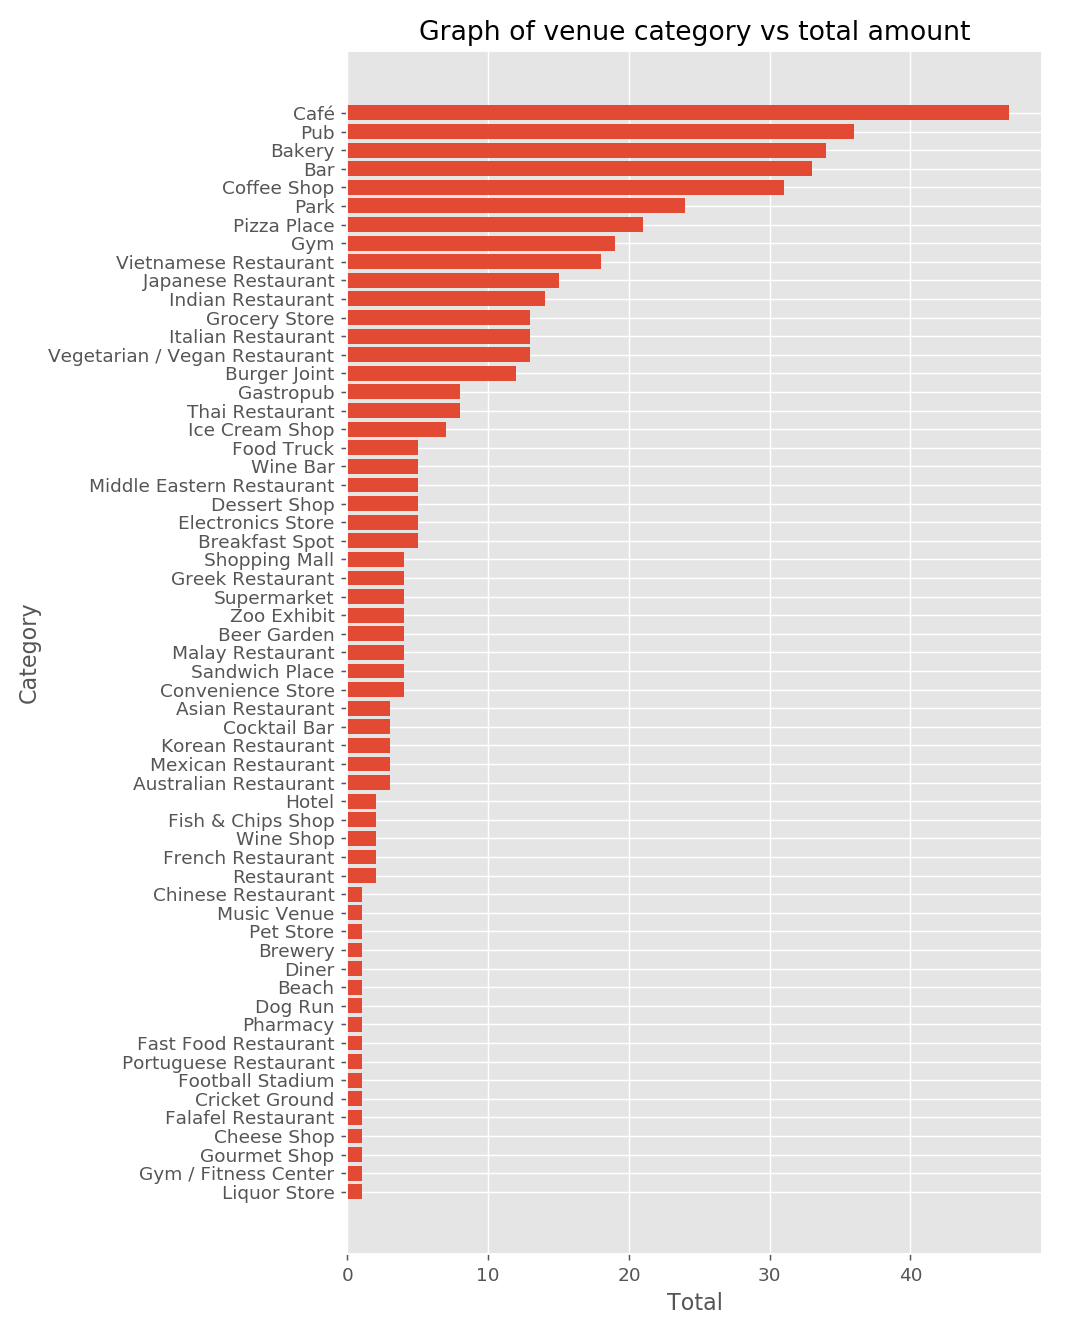

In [140]:
plot_cat(hc0)

## Cluster 1

In [141]:
get_most_common(hc1, 10)

[('Café', 24),
 ('Park', 19),
 ('Japanese Restaurant', 14),
 ('Coffee Shop', 13),
 ('Grocery Store', 12),
 ('Bar', 11),
 ('Gym', 11),
 ('Italian Restaurant', 10),
 ('Thai Restaurant', 8),
 ('Pizza Place', 8)]

<IPython.core.display.Javascript object>


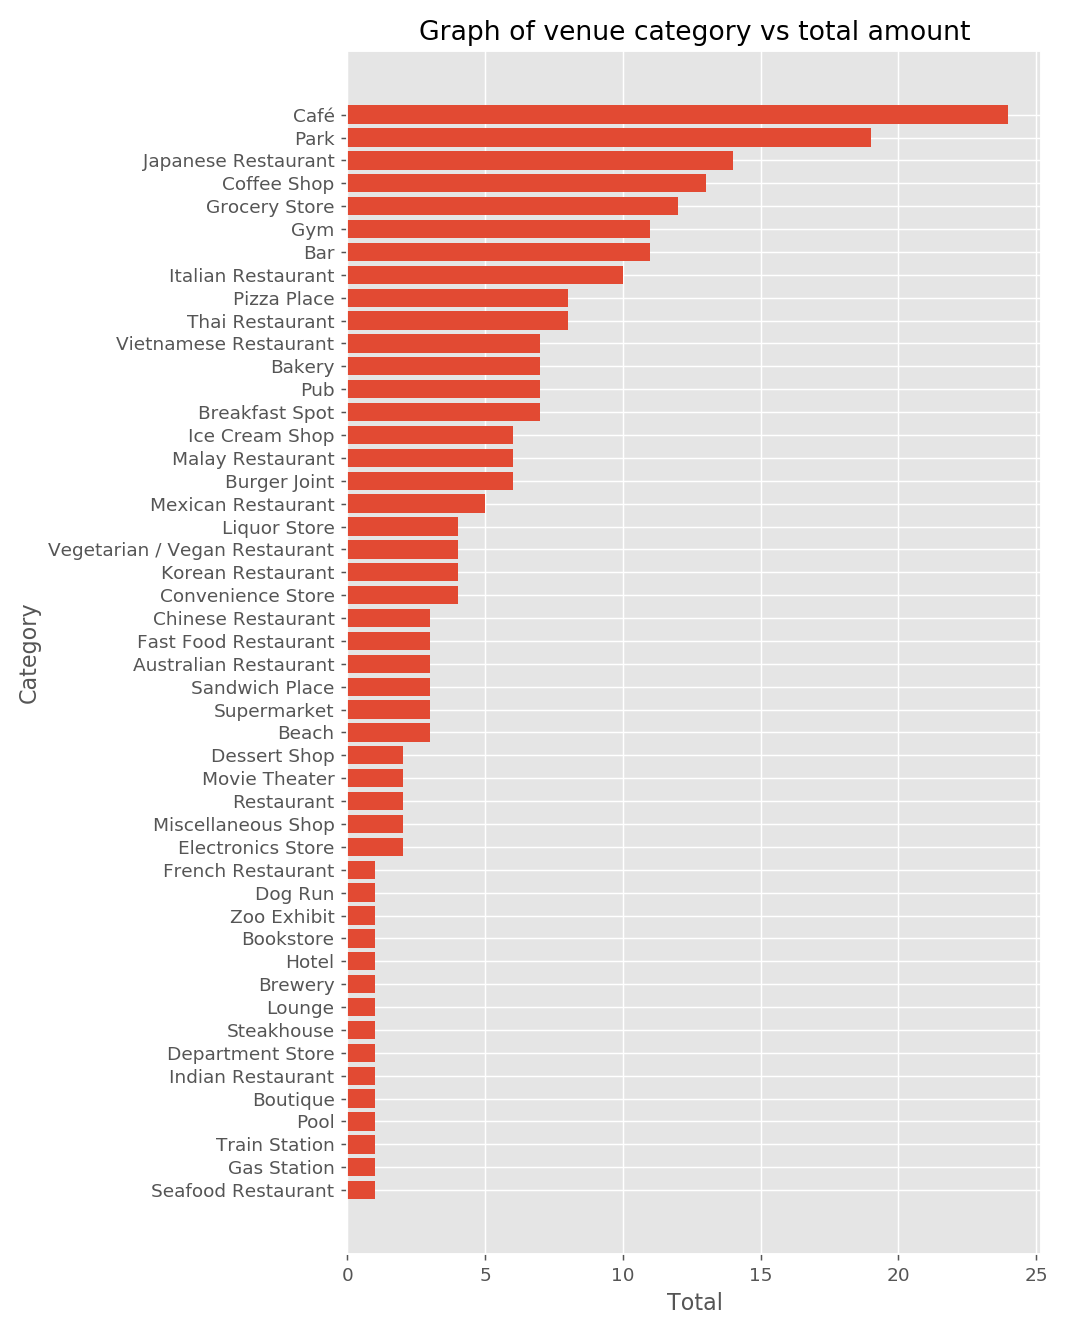

In [142]:
plot_cat(hc1)

## Cluster 2

In [143]:
get_most_common(hc2, 10)

[('Café', 37),
 ('Fast Food Restaurant', 37),
 ('Supermarket', 32),
 ('Grocery Store', 30),
 ('Portuguese Restaurant', 30),
 ('Sandwich Place', 26),
 ('Shopping Mall', 24),
 ('Convenience Store', 22),
 ('Vietnamese Restaurant', 19),
 ('Pizza Place', 12)]

<IPython.core.display.Javascript object>


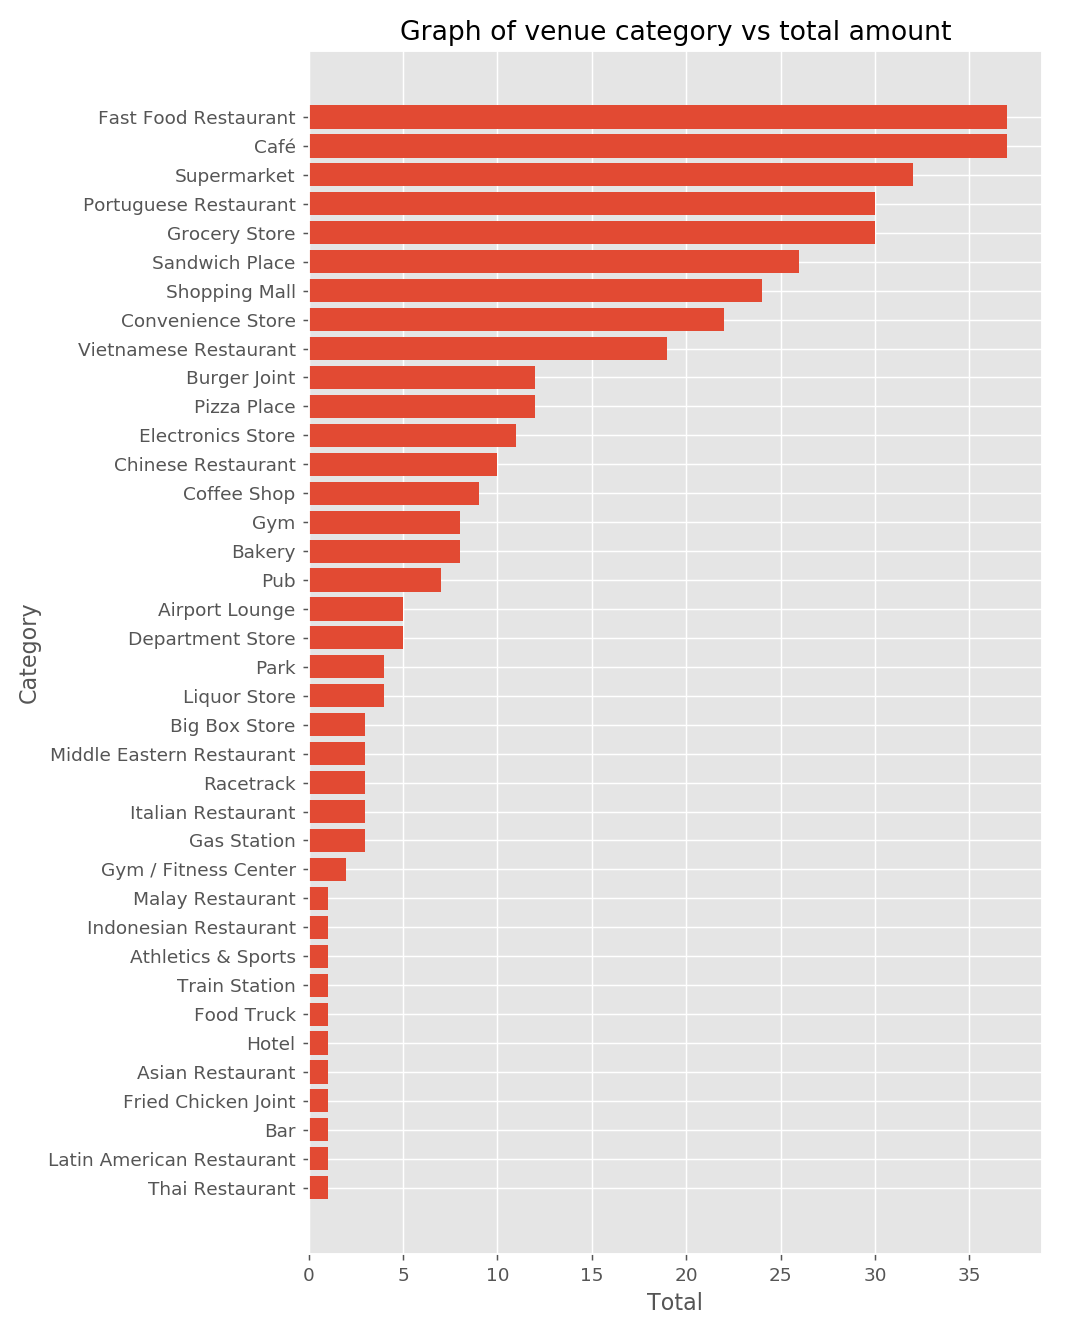

In [144]:
plot_cat(hc2)

## Cluster 3

In [145]:
get_most_common(hc3, 10)

[('Café', 2),
 ('Coffee Shop', 2),
 ('Japanese Restaurant', 2),
 ('Wine Bar', 1),
 ('Bar', 1),
 ('Cricket Ground', 1),
 ('Cocktail Bar', 1),
 ('Australian Restaurant', 1),
 ('Tennis Stadium', 1),
 ('Thai Restaurant', 1)]

<IPython.core.display.Javascript object>


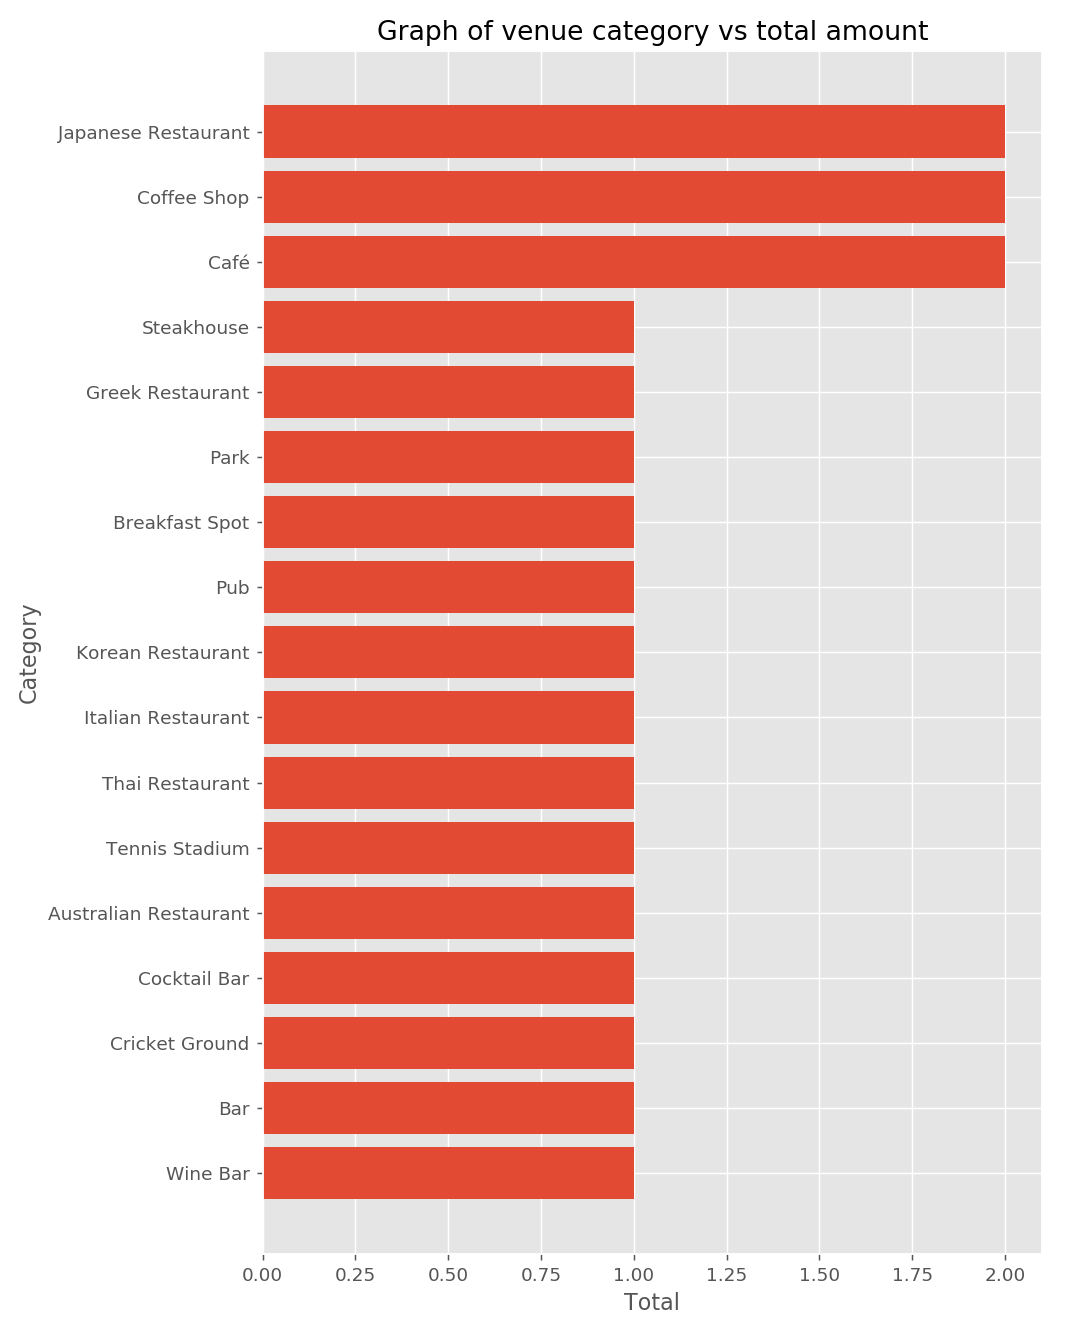

In [146]:
plot_cat(hc3)

## Cluster 4

In [147]:
get_most_common(hc4, 10)

[('Café', 43),
 ('Supermarket', 32),
 ('Sandwich Place', 30),
 ('Grocery Store', 29),
 ('Fast Food Restaurant', 28),
 ('Convenience Store', 21),
 ('Gym', 20),
 ('Electronics Store', 16),
 ('Japanese Restaurant', 14),
 ('Malay Restaurant', 14)]

<IPython.core.display.Javascript object>


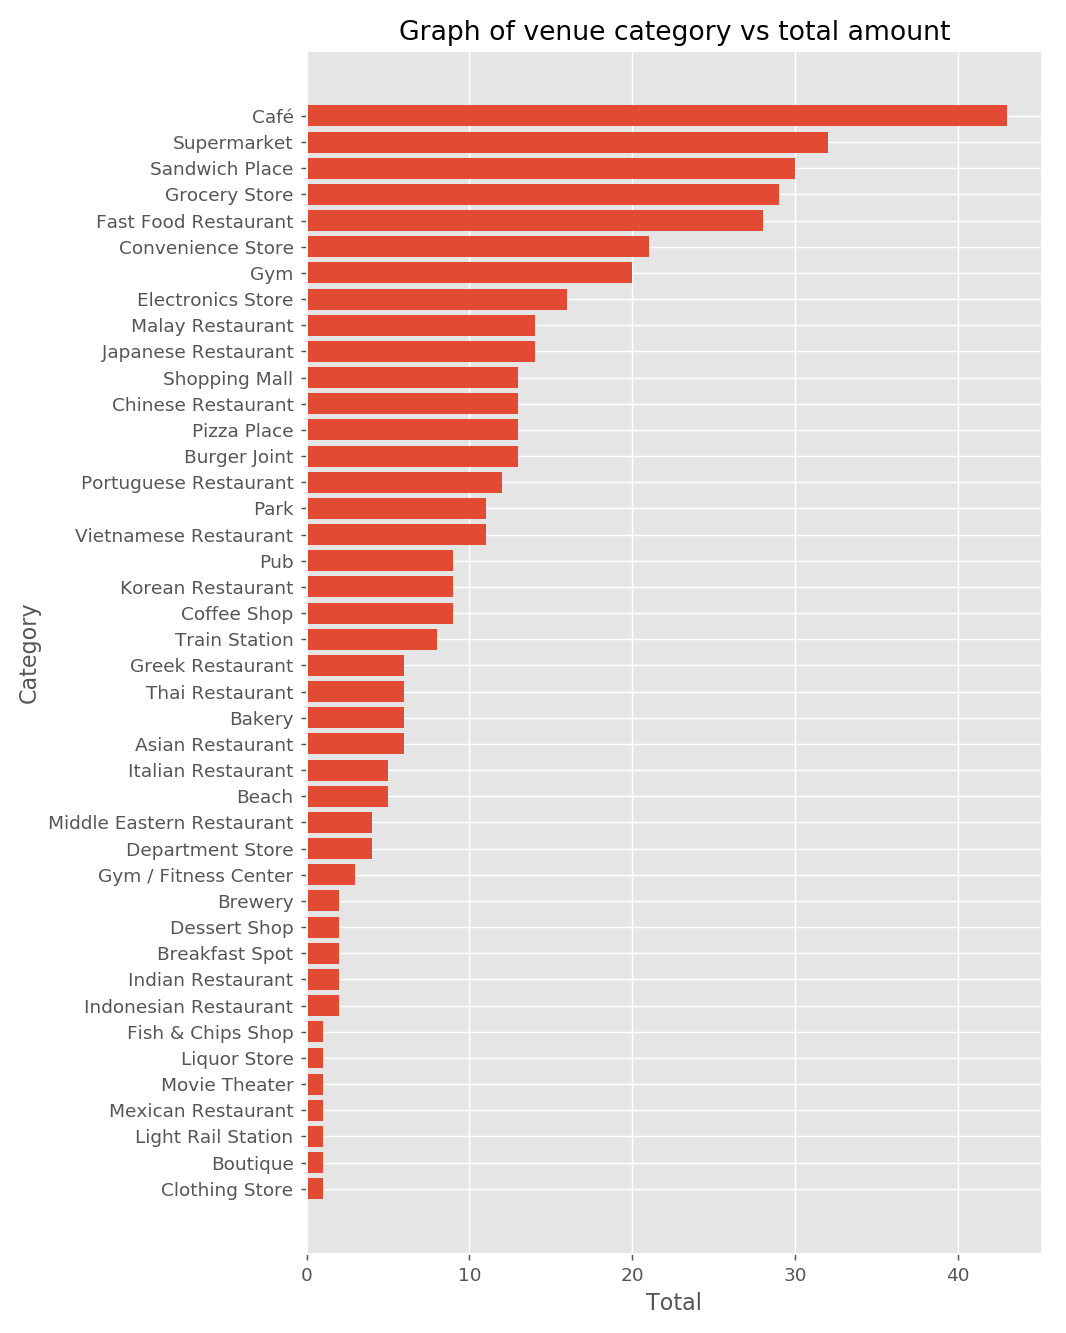

In [148]:
plot_cat(hc4)

### Housing

From the previous analysis of the suburb profiles it was shown that the inner eastern suburbs such as Toorak, Kooyong, Hawthorn, Deepdene and the like, contains the most valuable properties and is populated by higher income earners. Here, houses cost from 1,000,000 up to 5,000,000 while units are priced at 900,000 to 1,100,000. The median household income is also higher from 1600 to 2700 a week. While the lower value neighbourhood are mostly on the outer suburbs of Melbourne.

To begin with, the agglomerative clustering algorithm successfully clustered the high value areas into cluster 1 colour code in cyan. The mean house value here is 1,100,000 with a min of 700,000 and a max of 1,600,000. People living here are generally older with an average age of 38 and most are in their mid-30s with age going up in proportional to house value. As one would expect, the weekly household income is also high with most in the near or significantly above the 2k mark. One of the suburbs in this cluster is Parkville which is mostly made up of Melbourne Zoo with few residential properties. So, it should be taken with a grain of salt as it is an unusual suburb when compared to the rest.

The graph plotting the venue categories for this cluster shows a wide variety of venues especially restaurants. Japanese and Italian restaurants are considerably popular followed by a wide range of ethnic restaurants such as Thai, Vietnamese, Chinese, Korean, Malay, etc. In comparison fast food restaurants are one of the least popular on the list more so than vegan or vegetarian restaurants. This might be because wealthier people are more likely to be health conscious and can afford to buy healthier foods. In addition, other than Japanese and Italian eateries, other premium dining places includes French restaurants, steakhouses and seafood restaurants. Breakfast spots are also rather common. Bars and pubs are highly recommended here with bars being more popular than pubs.

Many shops and services are also available including movie theatres, breweries, hotels, boutiques, dessert shops, bookstores and electronics shops; while department store is the lowest on the list of stores and shops. Furthermore, there are places for sporting and recreational activities for example: pools, beaches and parks. Parks are the second highest common place behind cafes. This would make sense since, since it known that parks generally increase the value of nearby properties. Overall, we can say that this cluster contains premium to casual dining options together with many shops and recreational places.

A point of interest is cluster 3 in green which appears to contain suburbs that are very different such that the algorithm decided to put them into a separate cluster. The cluster has only two members: Toorak and East Melbourne. Their unusually high worth at 3,650,000 and 4,850,000 respectively resulted the suburbs standing out from the rest. Their proximity to the city would likely be a significant factor for their high value. In terms of venues, they are not much different from cluster 1 but in addition to the presence of a wine bar, cocktail bar, cricket ground and tennis stadium. 

In contrast, the lowest value areas are put into cluster 2 coloured in blue on the map. The mean value for a house here is only 600,000 going as low as 420,000 and a high of 870,000. The median household income ranges from 1000 to 1800 a week while median ages are from 30s to 40s.

Popular eatery here is fast food restaurants followed by Portuguese restaurants with fast food being the most popular. We also note that there isn't as many restaurants’ varieties here, in particular ethnic restaurants are considerably lower. Unlike wealthier suburbs, shopping malls and department stores are much more common. Pubs are bars are also not highly recommended with bars much less than pubs. In addition, the cluster in comparison is lacking in recreational spots with some parks being moderately common, racetracks and an athletic & sports category.
Moving on, cluster 4 in red mostly consist of suburbs in the City of Whitehorse at far eastern Melbourne and some in western Melbourne and south west regions. From the profile analysis of each suburb. These neighbourhoods are also rather valuable for housing with a mean of 1,000,000 a min of 560,000 and a max of 1,500,000.

The types of venues in cluster 4 appears to be a hybrid between cluster 1 and 2. Fast food is the most common restaurant type followed by many ethnic restaurants. Like cluster 1, Japanese restaurants are also popular. The presence of many Asian restaurants may suggest that suburbs here are popular with Asians. Entertainment places like Movie theatres, boutiques, shopping malls and departments store are present. Train stations are recommended here more so than other clusters. This is because a lot of people who work in the city also lives here. Interestingly, bars are not listed but there are several pubs and a couple of breweries. Parks are also a common sight together with a couple of beaches.

Finally, the last cluster is cluster 0 located in right Melbourne city and its surroundings suburbs spreading towards northern Melbourne. As expected, houses here are rather expensive costing on average of 1,100,000 from 700,000 to 1,600,000.

Being in and around the city, it's no surprise that these suburbs has many venues ranging from premium outlets, casual dining, shopping outlets and entertainment. Vietnamese, Japanese, Indian and Italian restaurants are highly rated. Vegetarian/vegan restaurants are also popular. There are ethnic restaurants including Thai, Middle eastern, Greek, Korean, Mexican, Chinese and Malay restaurants. Fast food and Portuguese restaurants are very much less popular than compared to other restaurants. Pubs and bars are the second and fourth highest recommended places behind cafes while other types like cocktail bars, brewery, beer gardens, wine bars, gastropubs are also available. As with any other city, shopping is a popular activity here. There are shopping malls, pet stores, pharmacy, electronics store, wine shops and gourmet shops. Entertainment centres are cricket grounds, football stadium, zoo exhibits, beaches and music venues.


### Units

The overall clusters representing the apartment units shares many similarities to that of housing. So, this part of the analysis will not go into too much detail for the venue categories of each suburb.

The first notable cluster is cluster 3. From the suburb profile of top value units, it can be seen that cluster 3 consist of the most valuable units with an average price tag of 1,000,000 a minimum of 900,000 and a maximum of 1,100,000; it is the only cluster to have a mean value of over a million. It also has the lowest number of suburbs of only 6. Like that of housing, these clusters are in the inner eastern suburbs of Melbourne. Thus, the venue categories are also similar to cluster 1 from housing with premium and casual locations present. The median age of the cluster is generally older between 39 to 47 years. As expected, the median household income is also high between 1.8k to 2.4k weekly.

The largest cluster is cluster 1. This cluster contains the city of Melbourne and its surrounding suburbs particularly towards the north. The mean value of units is 550,000. From the age groups it seems that younger people live in these suburbs especially within the city of Melbourne. The median age of Melbourne city itself is only 27 with its closest city suburbs of Docklands and Southbank at 30 years old. Melbourne city has two big universities: Melbourne University and RMIT, which means it has a large population of students while Melbourne city suburbs like Docklands is a financial district and residential area; therefore, is populated mostly by young professionals, hence the low ages. This also explains the lower income at 1.1k weekly for Melbourne while the city suburbs are higher at 1.8k. The overall cluster has a wide range of ages from 25 to early 40s but most people here are in their 30s. The same goes for income groups although this cluster contains some very high-income groups such as those in Cremorne and East Melbourne.

Interestingly the unit value of these suburbs is not very high as one would expect being populated by some of the highest income earners. The venues in these areas are similar to that of cluster 0 and 1 from the housing analysis containing many higher end locations typical of cities.

Like housing, the outer suburbs are the lowest value for units as well. These suburbs are grouped into cluster 2, having a mean value of only 380,000 up to 500,000. The ages are between early 30s to late 40s with most being in their mid-30s. The income groups here are not that much different than that of cluster 1. This cluster includes an anomaly that is the suburb of Carlton which is only one located in Melbourne city in the cluster. The reason was explained previously as the suburb is mostly a commercial area as well as being adjacent to Melbourne University, so it is populated by university students thus containing mostly small studio apartments. This is corroborated by the low weekly income of only 572 and low age group of 25. The category venues are similar to cluster 2 from housing with fast food restaurants being the most popular venue and generally less diversity in venues.

Finally, we have cluster 0 and 4 on opposite sides of the city. cluster 0 is located on the far eastern suburbs while cluster 4 is on the western suburbs of Melbourne. Cluster 0 is on average more valuable than 4 with a mean of 700,000 compared to 450,000. It is already known that eastern Melbourne is more valuable than western Melbourne. This is particularly true for units in places like Box hill and Glen Waverly when considering cluster 0 as these suburbs is known to be popular with wealthier people. Glen Waverly has a very high population quite like Melbourne CBD which has 49,000 people, the suburb also has many apartments. The venue categories for these two clusters are like that of cluster 4 in housing.

Overall, we can say that the cluster for units are very similar to that of housing with some exceptions due the differences in unit values. 


### Usage Examples

The findings from this study can help people looking to buy property. For example, say a couple is looking to buy a house, their budget is up to 1,000,000 and their work place is in the city. The analysis would suggest them houses in cluster 0, 2 or 4 in ordinance with their budget. They are also self-proclaimed ‘foodies’ who enjoy trying new eateries and a drink on Saturday nights. The clusters can then be narrowed down to either cluster 0 or 4. Houses in cluster 0 can be bought for as low as 700, 000 while cluster 4 as low as 560,000. Between the two, suburbs in cluster 4 is perhaps the best option as houses here generally cost lower than in cluster 0 while still having a large selection of places including many restaurants and pubs; also train stations are available so they can take the train to the city for work.

In another scenario, let’s say a person is planning to open a Teppanyaki restaurant (a type of Japanese grilled cuisine) and he wants to know which area is best for his new restaurant. The analysis would not suggest suburbs in cluster 2 since people there generally do not eat Japanese food based on the types of venues, while all other clusters are suitable for a Japanese restaurant. However, depending on how much he is willing to spend on his new business and how much he’s charging for food, we would recommend suburbs in either cluster 0 or 1 as Japanese restaurants appear to be popular with people here and they are wealthier so they may be more willing to spend on good food. Overall, cluster 1 would be the preferred option since it is between cluster 0 and 4, so the restaurant can better attract people living in these two clusters as well.


Housing cluster assignments:

- Cluster 0: ['high value housing', 'shopping', 'premium outlets', 'entertainment spots', 'moderate/high income']

- Cluster 1: ['very high value housing', 'inner suburbs', 'high income', 'premium outlets', 'casual dining', 'recreational spots']

- Cluster 2: ['low value housing', 'outer suburbs', 'fast food', 'casual dining', 'low/moderate income']

- Cluster 3: ['extremely high value housing', 'high/very high income', 'inner city suburb', 'premium outlets', 'recreational spots']

- Cluster 4: ['valuable housing', 'Suburban', 'moderate income', 'ethnic restaurants', 'shopping', 'entertainment spots']

Units cluster assignments:

- Cluster 0: ['very high value units', 'Suburban', 'moderate income', 'ethnic restaurants', 'shopping', 'entertainment spots']

- Cluster 1: ['high units', 'city/inner city', 'shopping', 'premium outlets', 'entertainment spots', 'low/moderate/high income']

- Cluster 2: ['low value units', 'outer suburbs', 'fast food', 'casual dining', 'low/moderate income']

- Cluster 3: ['extremely high value units', 'high/very high income', 'inner city suburb', 'premium outlets', 'recreational spots']

- Cluster 4: ['valuable units', 'Suburban', 'moderate income', 'ethnic restaurants', 'shopping', 'entertainment spots']

In [149]:
cls_0 = ['high value housing', 'shopping', 'premium outlets', 'entertainment spots', 'moderate/high income']
cls_1 = ['very high value housing', 'inner suburbs', 'high income', 'premium outlets', 'casual dining', 'recreational spots']
cls_2 = ['low value housing', 'outer suburbs', 'fast food', 'casual dining', 'low/moderate income']
cls_3 = ['extermely high value housing', 'high/very high income', 'inner city suburb', 'premium outlets', 'recreational spots']
cls_4 = ['valuable housing', 'Suburban', 'moderate income', 'ethnic restaurants', 'shopping', 'entertainment spots']

n = 5
Housing = hier_df_h.copy()

Housing['Cluster'] = Housing['Cluster'].map(dict(zip(np.arange(n), [cls_0, cls_1, cls_2, cls_3, cls_4])))

Housing.head()

,Cluster,Suburb,House price $ (2016),Latitude,Longitude,Most common ranking: 1,Most common ranking: 2,Most common ranking: 3,Most common ranking: 4,Most common ranking: 5,Most common ranking: 6,Most common ranking: 7,Most common ranking: 8,Most common ranking: 9,Most common ranking: 10
0,"[high value housing, shopping, premium outlets...",ABBOTSFORD,1187500.0,-37.804551,144.998854,Café,Vietnamese Restaurant,Coffee Shop,Pub,Bakery,Pizza Place,Bar,Thai Restaurant,Vegetarian / Vegan Restaurant,Breakfast Spot
1,"[high value housing, shopping, premium outlets...",ABERFELDIE,1300000.0,-37.759620,144.897457,Café,Electronics Store,Gym,Dessert Shop,Pub,Coffee Shop,Bakery,Japanese Restaurant,Thai Restaurant,Pizza Place
2,"[low value housing, outer suburbs, fast food, ...",AIRPORT WEST,745000.0,-37.722258,144.883494,Café,Supermarket,Grocery Store,Fast Food Restaurant,Sandwich Place,Shopping Mall,Convenience Store,Portuguese Restaurant,Electronics Store,Thai Restaurant
3,"[low value housing, outer suburbs, fast food, ...",ALBANVALE,439000.0,-37.746082,144.768562,Fast Food Restaurant,Café,Portuguese Restaurant,Grocery Store,Vietnamese Restaurant,Electronics Store,Convenience Store,Shopping Mall,Pizza Place,Burger Joint
4,"[very high value housing, inner suburbs, high ...",ALBERT PARK,1775000.0,-37.847799,144.962041,Café,Coffee Shop,Beach,Breakfast Spot,Bar,Pub,Burger Joint,Mexican Restaurant,Japanese Restaurant,Seafood Restaurant


In [150]:
cls_0 = ['very high value units', 'Suburban', 'moderate income', 'ethnic restaurants', 'shopping', 'entertainment spots']
cls_1 = ['high units', 'city/inner city', 'shopping', 'premium outlets', 'entertainment spots', 'low/moderate/high income']
cls_2 = ['low value units', 'outer suburbs', 'fast food', 'casual dining', 'low/moderate income']
cls_3 = ['exteremly high value units', 'high/very high income', 'inner city suburb', 'premium outlets', 'recreational spots']
cls_4 = ['valuable units', 'Suburban', 'moderate income', 'ethnic restaurants', 'shopping', 'entertainment spots']

n = 5

Units = hier_df_u.copy()

Units['Cluster'] = Units['Cluster'].map(dict(zip(np.arange(n), [cls_0, cls_1, cls_2, cls_3, cls_4])))

Units.head()

,Cluster,Suburb,Unit price $ (2016),Latitude,Longitude,Most common ranking: 1,Most common ranking: 2,Most common ranking: 3,Most common ranking: 4,Most common ranking: 5,Most common ranking: 6,Most common ranking: 7,Most common ranking: 8,Most common ranking: 9,Most common ranking: 10
0,"[high units, city/inner city, shopping, premiu...",ABBOTSFORD,580000.0,-37.804551,144.998854,Café,Vietnamese Restaurant,Coffee Shop,Pub,Bakery,Pizza Place,Bar,Thai Restaurant,Vegetarian / Vegan Restaurant,Breakfast Spot
1,"[high units, city/inner city, shopping, premiu...",ABERFELDIE,510000.0,-37.759620,144.897457,Café,Electronics Store,Gym,Dessert Shop,Pub,Coffee Shop,Bakery,Japanese Restaurant,Thai Restaurant,Pizza Place
2,"[high units, city/inner city, shopping, premiu...",AIRPORT WEST,530000.0,-37.722258,144.883494,Café,Supermarket,Grocery Store,Fast Food Restaurant,Sandwich Place,Shopping Mall,Convenience Store,Portuguese Restaurant,Electronics Store,Thai Restaurant
3,"[very high value units, Suburban, moderate inc...",ALBERT PARK,730000.0,-37.847799,144.962041,Café,Coffee Shop,Beach,Breakfast Spot,Bar,Pub,Burger Joint,Mexican Restaurant,Japanese Restaurant,Seafood Restaurant
4,"[low value units, outer suburbs, fast food, ca...",ALBION,240000.0,-37.776380,144.816071,Café,Grocery Store,Portuguese Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Bakery,Chinese Restaurant,Latin American Restaurant,Pub,Sandwich Place


In [151]:
gc.collect()

142

## Conclusion

In conclusion, the datasets for each suburb as well as the median property worth has been analysed. All relevant datasets were obtained, cleaned and explored; followed by applying an unsupervised learning method that is agglomerative clustering model. The results showed that, there is a relationship between property values and the type of venues around them, places with more amenities and eateries have higher value property than those without. For future work, more detailed datasets should be used to better estimate property values other than just the median. In addition, things like property size, number of bedrooms and bathrooms and age should also be included. The value overtime could also be considered. 

Fore more details please see the report for this project